# Orinal imported code from Izak's main.py file

Usually, run this cell upon opening!

In [12]:
"""
This is code for SRAM memory dump data analysis.
There are multiple "main" functions which all have names that start with "main_"
that are like scripts to create different plots and files from input data dump text files.
"""

import os, sys, re
from typing import Any
from timeit import default_timer as timer
from operator import xor
from typing import BinaryIO, Iterable, TextIO
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from matplotlib.colors import ListedColormap


BITS_PER_WORD = 16 # SRAM bits per word
NUM_WORDS = 2**18  # SRAM number of words (addresses)
NUM_BITS = BITS_PER_WORD * NUM_WORDS
HEX4_WORD_PATTERN = re.compile(r"[a-f0-9]{4}", re.IGNORECASE) # Hex dump pattern


def file_read_hex4_dump_as_words(file_in: TextIO, num_words: int) -> np.ndarray:
    '''Load a hex4 memory dump file as a 1D array of 16-bit integer words.'''
    result = np.empty(num_words, dtype='uint16')
    for i in range(num_words):
        result[i] = file_read_next_hex4(file_in)
    return result


def diff_puf_and_trials_dump(puf_file_name: str, trials_dump_file_name: str, num_words=NUM_WORDS) -> tuple[tuple[float, float], ...]:
    '''Run a diff against the PUF file and multiple memory dumps that come from the Arduino'''
    data_result: list[tuple[float, float]] = list()
    print(f"Diffing file \"{puf_file_name}\" against trials file \"{trials_dump_file_name}\"")
    with open(puf_file_name, "rb") as puf_file:
        with open(trials_dump_file_name, "rb") as trials_file:
            val_ms = 0.0
            percent_diff = 0.0
            while (line := trials_file.readline().decode()):
                line = line.strip()
                if line.startswith("Beginning trial"): # once we find a start of trial, record the delay value (in milliseconds)
                    # extract delay value from the trial line
                    match = re.search(r"([0-9]+\.[0-9]+)ms", line) # Look for decimal number "<n>.<n>ms"
                    assert(match is not None)
                    val_ms = float(match.group(1))
                elif line == "[begin memory dump]": # once we find the start of the memory dump inside a trial, read files & get the bit difference
                    print(f"{len(data_result) + 1}", end=' ')
                    # get memory dump bits and diff it with the PUF file
                    puf_file.seek(0) # go to beginning of PUF file
                    a_weight, b_weight, diff = bit_diff_within_files(puf_file, trials_file, num_words, puf_file_name, trials_dump_file_name)
                    #report_file_bit_diff(puf_file_name, trials_dump_file_name, a_weight, b_weight, diff)
                    percent_diff = percent(diff, num_words * BITS_PER_WORD)
                    data_result.append( (val_ms, percent_diff,) )    
    print()
    return tuple(data_result)      


def remanence_experiment_get_images(dump_file, image_width: int, image_height: int) -> dict[float, np.ndarray]:
    # Use recursive case to accept a 'str' or a binary file for the first function argument
    if isinstance(dump_file, str):
        with open(dump_file, 'rb') as dump_file:
            assert (not isinstance(dump_file, str))
            return remanence_experiment_get_images(dump_file, image_width, image_height)
        
    delay_image_pairs: dict[float, np.ndarray] = dict()
    while (line := dump_file.readline().decode('ascii')):
        delay_str = file_seek_next_delay_line(dump_file)
        if delay_str is None:
            # Reached the end of the dump_file's memory dumps
            break
        current_delay = float(delay_str)
        file_seek_next_data_dump(dump_file)
        delay_image_pairs[current_delay] = file_read_image(dump_file, image_width, image_height)
    return delay_image_pairs


def file_load_delays(dump_file: TextIO, num_captures: int) -> np.ndarray:
    '''Collect `num_captures` delay values from a data dump file (this skips over any data dumps in-between).'''
    results = np.empty(num_captures)
    for i in range(num_captures):
        line = file_seek_next_delay_line(dump_file)
        assert line is not None
        results[i] = float(line)
    return results


def file_seek_next_delay_line(file_in: TextIO) -> str | None:
    pattern_comp = re.compile(r"delay of (\d+\.\d+)ms", re.IGNORECASE)
    while line := file_in.readline():
        if match := re.search(pattern_comp, line):
            return match.group(1)
    return None


def file_seek_next_data_dump(file_in) -> str | None:
    while line := file_in.readline():
        if line.strip() == "[begin memory dump]":
            return line
    return None


def file_seek_next_data_dump_and_count_it(file_in: BinaryIO) -> int:
    '''Find the size of the next data dump, and keep the read offset at the beginning of that data dump'''
    if not file_seek_next_data_dump(file_in):
        raise ValueError('did not find the start of a data dump')
    file_offset = file_in.tell() # Save offset so we can go back to it later
    count = file_count_data_dump(file_in)
    file_in.seek(file_offset) # Reset to the beginning of the original dump
    return count


def file_count_data_dump(file_in: BinaryIO) -> int:
    '''Count the number of lines from the current position in a file before encountering the "end of memory dump" marker/line.'''
    count = 0
    while line := file_in.readline().decode('ascii'):
        if line.strip() == "[end memory dump]":
            break
        count += 1
    return count


def bit_diff_within_files(file_a, file_b, num_words_to_read: int = NUM_WORDS, file_a_name="file_a", file_b_name="file_b") -> tuple[int, int, int]:
    a_weight = 0
    b_weight = 0
    different = 0
    for i in range(num_words_to_read):
        try:
            word_a = file_read_next_hex4(file_a)
        except ValueError as e:
            print(f"[ERROR] exception when reading word #{i} from \"{file_a_name}\"")
            raise e
        
        try:
            word_b = file_read_next_hex4(file_b)
        except ValueError as e:
            print(f"[ERROR] exception when reading word #{i} from \"{file_b_name}\"")
            raise e

        #print(f"#{i}: A {word_a} ; B {word_b}")
        
        a_b_diff = bit_difference(word_a, word_b)
        assert(a_b_diff >= 0)
        assert(a_b_diff <= 16)
        different += a_b_diff
        a_weight += bit_weight(word_a)
        b_weight += bit_weight(word_b)

    return a_weight, b_weight, different


def find_bit_flip(file_in, bit_index: int, bit_is_initially_one: bool) -> float | None:
    '''Return the experiment delay value (in milliseconds) at which a given bit in a memory dump flips (will be SLOW if iterating every bit and calling this function)'''
    # Allow the first argument to be a string or already-opened file
    if isinstance(file_in, str):
        with open(file_in, "rb") as arg:
            return find_bit_flip(arg, bit_index, bit_is_initially_one)

    word_index = bit_index // BITS_PER_WORD
    sub_index = bit_index % BITS_PER_WORD

    min_t: float | None = None
        
    while (delay_str := file_seek_next_delay_line(file_in)) is not None:
        t = float(delay_str)
        if (min_t is not None) and (t > min_t):
            # Skip searching for a flip in a later time than already found
            continue
        file_seek_next_data_dump(file_in)
        # Skip the first words of the memory dump before the bit index (if any)
        file_skip_hex4(file_in, word_index)
        word = file_read_next_hex4(file_in)
        bit = (word >> sub_index) & 1
        if (bit == 1) != bit_is_initially_one:
            if (min_t is None) or (t < min_t):
                # First, or Earlier bit flip detected here
                min_t = t

    # If this point is reached and min_t is still NONE, the bit never flipped in the given memory dumps
    return min_t


def file_find_bit_flips(file_in, expected_word_count: int | None = None, verbose=0, word_flip=True) -> tuple[tuple[int | None, ...], tuple[float, ...]]:
    '''Get a list for all of the bits in a memory dump(s) file and the delay times where they flip.'''

    # Allow the first argument to be a string or already-opened file
    if isinstance(file_in, str):
        with open(file_in, "rb") as arg:
            return file_find_bit_flips(arg, expected_word_count, verbose, word_flip)

    if verbose > 0:
        print("find_flip_bits()...")

    word_count = file_seek_next_data_dump_and_count_it(file_in) # file offset will be right before the first dump's data after this call

    if verbose > 0:
        print(f"For the first data dump in this file, {word_count=}")

    if (expected_word_count is not None) and (word_count != expected_word_count):
        print(f"expected {expected_word_count} words but found {word_count} instead")
        if expected_word_count > word_count:
            raise ValueError(f"actual {word_count=} < {expected_word_count=}")
        else:
            word_count = expected_word_count

    bit_count = word_count * BITS_PER_WORD

    # Read the initial data dump and use it as the starting values
    original_words: list[int] = [ file_read_next_hex4(file_in) for _ in range(word_count) ]

    # Array indeices are 0..(number of bits), that indicate at what time (if any) a bit was first seen to flip
    bit_flip_times: list[int | None] = [ None for _ in range(bit_count) ]

    # List of dump delays (maps a 'dump_index' in the 'bit_flip_times' to a delay float value)
    delays: list[float] = []

    # Iterate over all data dumps from the file...
    dump_index = 0
    while (delay_str := file_seek_next_delay_line(file_in)) is not None:
        # Save the delay for this dump index
        delays.append(float(delay_str))

        # check each new dump's word's bits
        file_seek_next_data_dump(file_in)
        for word_index in range(word_count):
            word = file_read_next_hex4(file_in)
            for bit_i in range(BITS_PER_WORD):
                # Index into the bit flip array
                bit_flip_index = (word_index * BITS_PER_WORD) + bit_i
                # Check each bit that has not yet flipped
                if bit_flip_times[bit_flip_index] is None:
                    original_bit = (original_words[word_index] >> bit_i) & 1
                    if word_flip:
                        this_bit = (word >> (15 - bit_i)) & 1
                    else:
                        this_bit = (word >> bit_i) & 1
                    bit_flipped = (original_bit != this_bit)
                    if bit_flipped:
                        bit_flip_times[bit_flip_index] = dump_index
        
        dump_index += 1

    if verbose > 0:
        print(f"Read {dump_index} dumps")

    return tuple(bit_flip_times), tuple(delays)



def file_find_bit_flips_v2(original_file, file_in, num_words: int, word_flip=True) -> np.ndarray:
    '''
    Get a list for all of the bits in a memory dump(s) file and the delay times where they first flip.
    This is an improvement over the original 'file_find_bit_flips' function.
    '''

    # Allow the first 2 arguments to be a string or already-opened file
    if isinstance(original_file, str):
        with open(original_file, 'rb') as arg:
            return file_find_bit_flips_v2(arg, file_in, num_words, word_flip)
    if isinstance(file_in, str):
        with open(file_in, "rb") as arg:
            return file_find_bit_flips_v2(original_file, arg, num_words, word_flip)

    num_bits = num_words * BITS_PER_WORD
    original_words = file_read_hex4_dump_as_words(original_file, num_words)

    # Array of bit flip time
    time_not_set = -1
    bit_flip_times = np.full(shape=num_bits, fill_value=time_not_set)

    # Iterate over all data dumps from the file...
    while (delay_str := file_seek_next_delay_line(file_in)) is not None:
        # Save the delay for this dump index
        t = float(delay_str)
        assert(t >= 0.0)
        # check each new dump's word's bits
        file_seek_next_data_dump(file_in)
        for word_index in range(num_words):
            try:
                word = file_read_next_hex4(file_in)
            except ValueError as e:
                print(f"NOTE: error at t = {t}, word_index = {word_index}")
                raise e
            for bit_i in range(BITS_PER_WORD):
                # Index into the bit flip array
                bit_flip_index = bit_i + (word_index * BITS_PER_WORD)
                # Check each bit that has not yet flipped
                recorded_time = bit_flip_times[bit_flip_index]
                if (recorded_time == time_not_set) or (t < recorded_time):
                    original_bit = (original_words[word_index] >> bit_i) & 1
                    if word_flip:
                        this_bit = (word >> (15 - bit_i)) & 1
                    else:
                        this_bit = (word >> bit_i) & 1
                    bit_flipped = (original_bit != this_bit)
                    if bit_flipped:
                        bit_flip_times[bit_flip_index] = t

    return bit_flip_times


def file_find_bit_flips_count(original_file: TextIO, file_in: TextIO, num_words: int) -> dict:
    '''
    Find how many bits flip from the original data for each dump taken at remanence time delay.
    '''
    # DO NOT allow the first 2 arguments to be a string or already-opened file
    if isinstance(original_file, str):
        raise TypeError("`original_file` given as a string instead of an open file")
    if isinstance(file_in, str):
        raise TypeError("`file_in` given as a string instead of an open file")

    original_words = file_read_hex4_dump_as_words(original_file, num_words)

    # Array of words to record if the first time a bit flipped has been recorded
    # (a 0 bit means not seen to flip yet, and a 1 bit means that it has previously flipped)
    bit_flips = np.zeros(shape=num_words, dtype="uint16")

    # Result to map a time to the number of new bit flips at that time
    flip_counts: dict[float, int] = dict()

    # Iterate over all data dumps from the file...
    while (delay_str := file_seek_next_delay_line(file_in)) is not None:
        # Save the delay for this dump index
        t = float(delay_str)
        flip_counts[t] = 0
        assert(t >= 0.0)
        # check each new dump's word's bits
        file_seek_next_data_dump(file_in)
        for word_index in range(num_words):
            try:
                word = file_read_next_hex4(file_in)
            except ValueError as e:
                print(f"NOTE: error at t = {t}, word_index = {word_index}")
                break#raise e
            original_word = original_words[word_index]
            new_mask = ~(bit_flips[word_index])
            diff = word ^ original_word
            # Get 1s only at bits that are newly flipped for this 't' time
            new_flips = diff & new_mask
            # Record these bits as flipped for next time
            bit_flips[word_index] |= new_flips
            # Add this word's flip count to the total flip count for this 't' time
            flip_counts[t] += hamming_weight(new_flips)

    return flip_counts


def file_find_bit_flips_count_with_natural_bits(original_file: TextIO, natural_file: TextIO, file_in: TextIO, num_words: int) -> dict:
    '''
    Find how many bits flip from the original data for each dump taken at remanence time delay.
    '''

    original_words = file_read_hex4_dump_as_words(original_file, num_words)
    natural_mask = file_read_hex4_dump_as_words(natural_file, num_words)

    # Array of words to record if the first time a bit flipped has been recorded
    # (a 0 bit means not seen to flip yet, and a 1 bit means that it has previously flipped)
    bit_flips = np.zeros(shape=num_words, dtype="uint16")

    # Result to map a time to the number of new bit flips at that time
    flip_counts: dict[float, int] = dict()

    # Iterate over all data dumps from the file...
    while (delay_str := file_seek_next_delay_line(file_in)) is not None:
        # Save the delay for this dump index
        t = float(delay_str)
        assert t >= 0
        flip_counts[t] = 0
        
        file_seek_next_data_dump(file_in)
        data_words = file_read_hex4_dump_as_words(file_in, num_words)

        # check each new dump's word's bits
        for i, word in enumerate(data_words):
            # Set 1s at bit flips for natural bits that are newly flipped for this 't' time
            flip_word = (word ^ original_words[i]) & (~(bit_flips[i])) & (~natural_mask[i])

            # Record these bits as flipped for next time
            bit_flips[i] |= flip_word

            # Add this word's flip count to the total flip count for this 't' time
            flip_counts[t] += hamming_weight(flip_word)

    return flip_counts


def file_skip_hex4(file_in, count: int):
    '''Skip 'count' amount of 4-digit hex words in a file'''
    for i in range(count):
        file_read_next_hex4(file_in)


def file_hamming_weight(file_in: TextIO, num_words: int) -> int:        
    return sum(map(hamming_weight, file_read_hex4_dump_as_words(file_in, num_words)))


def bit_diff_files(file_name_a: str, file_name_b: str, num_words: int=NUM_WORDS, do_print=True) -> int:
    if do_print:
        print(f"Comparing bits from data files '{file_name_a}' and '{file_name_b}'...")

    with open(file_name_a, "r") as file_a:
        with open(file_name_b, "r") as file_b:
            a_hw, b_hw, diff = bit_diff_within_files(file_a, file_b, num_words)

    if do_print:
        report_file_bit_diff(file_name_a, file_name_b, a_hw, b_hw, diff, num_words*BITS_PER_WORD)

    return diff


def bit_diff_files_full_ratio(file_a: str, file_b: str, num_words: int=NUM_WORDS) -> tuple[float, float, float]:
    '''With already open memory dump files, get the Hamming weights and the bits different between them (as ratios of the whole file).'''
    a_hw, b_hw, diff = bit_diff_within_files(file_a, file_b, num_words)
    num_bits = num_words * BITS_PER_WORD
    a, b, d = a_hw/num_bits, b_hw/num_bits, diff/num_bits
    assert(0.0 <= a <= 1.0)
    assert(0.0 <= b <= 1.0)
    assert(0.0 <= d <= 1.0)
    return a, b, d


def report_file_bit_diff(file_name_a: str, file_name_b: str, a_hw: int, b_hw: int, diff: int, num_bits=NUM_BITS) -> None:
    print(f"* Hamming weight for \"{file_name_a}\": {a_hw:,} ({percent(a_hw, NUM_BITS):.3f}%)")
    print(f"* Hamming weight for \"{file_name_b}\": {b_hw:,} ({percent(b_hw, NUM_BITS):.3f}%)")
    print(f"* Number of bits different between the two files: {diff:,} which is {percent(diff, num_bits):.3f}% of the given total size")


def file_skip_space(file_in):
    while file_in.peek(1)[:1].decode('ascii').isspace():
        file_in.read(1)


def file_read_next_hex4(file_in: TextIO) -> int:
    '''
    Within an already-open file for reading, skip whitespace and then read a 4-character hex number.
    Raises a 'ValueError' if it cannot read that from the file.
    '''
    while True:
        c = file_in.read(1)
        if not c:
            break
        if not c.isspace():
            word = c + file_in.read(3)
            if len(word) != 4:
                break
            return int(word, 16)
    raise ValueError(f"unexpected end of file at position #{file_in.tell()}")


def file_read_next_hex4_no_error(file_in) -> int | None:
    '''Within an already-open file for reading, skip whitespace and then read a 4-digit hex number, or return 'None' upon failure'''
    try:
        return file_read_next_hex4(file_in)
    except ValueError:
        return None
    

def bit_differences(seq_a: Iterable[int], seq_b: Iterable[int]) -> int:
    return sum( bit_difference(a, b) for (a, b) in zip(seq_a, seq_b) )


def bit_difference(word_a: int, word_b: int) -> int:
    '''Find the number of bits different between two integers (in the binary representation of the numbers)'''
    return hamming_weight(xor(word_a, word_b))


def hamming_weight(x: int) -> int:
    '''Get the Hamming weight (the number of bits set to 1) of an integer. Same as the bit_weight() function.'''
    # result = 0
    # while x:
    #     result += 1
    #     x &= x - 1
    # return result
    return int(x).bit_count() # Use Python's built-in method


# Convert Hamming Weight function to numpy vectorized function for later
hw_vec_fn = np.vectorize(hamming_weight)


def bit_weight(x: int) -> int:
    '''Get the Hamming weight (the number of bits set to 1) of an integer. Same as the hamming_weight() function.'''
    return hamming_weight(x)


def check_file_increasing(file_in, num_words: int = NUM_WORDS) -> bool:
    '''check that each word value in a memory dump file is increasing'''
    print("check_file_increasing...")
    result = True
    for i in range(num_words):
        x = file_read_next_hex4(file_in)
        y = i % (16**4)
        if x != y:
            print(f"word #{i} is {x} instead of {y}")
            result = False
    print("ok")
    return result


def percent(numerator: float, denominator: float) -> float:
    return 100.0 * float(numerator) / float(denominator)


def hex4(x: int) -> str:
    '''
    Turn an int into a 4-digit hex string, with no prefix.
    (Requires that the int 'x' is within the range 0000 to FFFF too)
    '''
    if not isinstance(x, int): 
        raise TypeError(f"'x' should be an int, not {type(x)}")
    if x < 0x0000: 
        raise ValueError("'x' should not be negative")
    if x > 0xffff: 
        raise ValueError(f"'x' should not be bigger than 0xFFFF ({0xFFFF} in decimal)")
    return f"{x:04X}"


def hex4_i(x) -> str:
    '''Convert x to be a 4-digit hex value. Try to force x to be an int.'''
    return hex4(int(x))


def bin16(x: int) -> str:
    if not isinstance(x, int): 
        raise TypeError("'x' should be an int")
    if x < 0x0000: 
        raise ValueError("'x' should not be negative")
    if x > 0xffff: 
        raise ValueError(f"'x' should not be bigger than 0xFFFF ({0xFFFF} in decimal)")
    return f"{x:016b}"


def convert_hex_file(file_name_in: str, file_name_out: str):
    '''Convert a file that has one hex word like 0x0 per line to a denser format of 0-padded hex words'''
    print(f"Converting hex file \"{file_name_in}\" to \"{file_name_out}\"...")

    line_count = 0
    with open(file_name_in, "r") as file_in:
        with open(file_name_out, "w") as file_out:
            for line in file_in.readlines():
                if not line.strip():
                    break
                print(hex4(int(line[2:], 16)), file=file_out, end='')
                line_count += 1

    print(f"Data is {line_count} lines = {line_count*16:,} total bits")
    print("Done")


def file_read_image(file_in: TextIO, img_width: int, img_height: int) -> np.ndarray:
    '''Read 4-digit hex words from a dump file and convert it to a 2D numpy array, to act as a binary image'''        
    bits_2d = np.zeros([img_height, img_width], dtype='int16')

    num_img_bits = img_width * img_height
    num_img_words = round(num_img_bits / 16)
    
    for word_i in range(num_img_words):
        word = file_read_next_hex4(file_in)

        # break down a 16-bit word into bits
        for bit_i in range(16):
            i = (word_i * 16) + bit_i
            row = i // img_width
            col = i % img_width

            # set image bit to 1 if #'bit_i' is 1 (note that the 2d array is already initialized to 0)
            if (word & (1 << (15 - bit_i))):
                bits_2d[row, col] = 1

    return bits_2d


def convert_words_to_image(words: np.ndarray, img_width: int, img_height: int) -> np.ndarray:
    '''Convert a numpy array of words to a 2D numpy array of bits'''
    if (img_width * img_height / 16) > words.shape[0]:
        raise ValueError("the given words array is too short to contain the given image dimensions")
    
    # img_num_words = math.ceil(img_width * img_height / 16)
    bits_2d = np.zeros([img_height, img_width], dtype='bool')
    for word_i, word in enumerate(words):
        try:
            # break down a 16-bit word into bits
            for bit_i in range(16):
                i = (word_i * 16) + bit_i
                row = i // img_width
                col = i % img_width
                # set image bit to 1 if bit #'bit_i' is 1 (note that the 2d bits array is already initialized to 0)
                if (word & (1 << (16 - 1 - bit_i))):
                    bits_2d[row, col] = 1
        except IndexError:
            break
    return bits_2d


def files_read_and_calc_data_loss(pu_read_file, data_original_file, pu_ref_file, num_words: int, num_word_skip: int = 0) -> float:
    '''
    Data Loss % = [# of set bits(Image_original XOR PU_read)] / [# of set bits(Image_original XOR PU_ref)] * 100%.
    Implemented for files.
    '''
    set_bits_top = 0
    set_bits_bot = 0

    ## Iterate the data words of each of the 3 files simultaneously
    for i in range(num_words):
        pu_read_word = file_read_next_hex4(pu_read_file)
        original_word = file_read_next_hex4(data_original_file)
        pu_ref_word = file_read_next_hex4(pu_ref_file)

        # Disregard the initial few words (if the argument 'num_word_skip' is more than 0)
        if i < num_word_skip:
            continue

        set_bits_top += bit_weight(xor(original_word, pu_read_word))
        set_bits_bot += bit_weight(xor(original_word, pu_ref_word))

    # assert(set_bits_top <= set_bits_bot)
    return percent(set_bits_top, set_bits_bot)


def files_data_loss_percent(data_original_file: TextIO, pu_read_trials_file: TextIO, pu_ref_file: TextIO, num_words: int, num_word_skip: int = 0) -> list[tuple[float, float]]:
    '''Run a data loss calculation against the PUF file and multiple memory dumps that come from the Arduino'''

    data_result: list[tuple[float, float]] = []
    val_ms = None
    while (line := pu_read_trials_file.readline()):
        line = line.strip()
        if line.startswith("Beginning trial"): # once we find a start of trial, record the delay value (in milliseconds)
            assert val_ms is None
            # extract delay value from the trial line
            match = re.search(r"([0-9]+\.[0-9]+)ms", line) # Look for decimal number "<n>.<n>ms"
            assert match is not None
            val_ms = float(match.group(1))
        elif line == "[begin memory dump]": # once we find the start of the memory dump inside a trial, read files & get the bit difference
            assert val_ms is not None
            # get memory dump bits and diff it with the PUF file
            pu_ref_file.seek(0) # reset to beginning of PUF file so 'files_read_and_calc_data_loss' can read its data again
            data_original_file.seek(0) # reset to beginning of original data/image file so 'files_read_and_calc_data_loss' can read its data again
            trial_data_loss = files_read_and_calc_data_loss(pu_read_trials_file, data_original_file, pu_ref_file, num_words, num_word_skip)
            data_result.append((val_ms, trial_data_loss))
            val_ms = None

    return data_result


def files_data_loss_count(data_original_file: TextIO, pu_read_trials_file: TextIO, pu_ref_file: TextIO, num_words: int) -> list[tuple[float, float]]:
    '''Run a data loss calculation against the PUF file and multiple memory dumps that come from the Arduino'''

    data_result: list[tuple[float, float]] = []
    val_ms = None
    while (line := pu_read_trials_file.readline()):
        line = line.strip()
        if line.startswith("Beginning trial"): # once we find a start of trial, record the delay value (in milliseconds)
            assert val_ms is None
            # extract delay value from the trial line
            match = re.search(r"([0-9]+\.[0-9]+)ms", line) # Look for decimal number "<n>.<n>ms"
            assert match is not None
            val_ms = float(match.group(1))
        elif line == "[begin memory dump]": # once we find the start of the memory dump inside a trial, read files & get the bit difference
            assert val_ms is not None
            # get memory dump bits and diff it with the PUF file
            pu_ref_file.seek(0) # go to beginning of PUF file
            data_original_file.seek(0) # go to beginning of original data/image file

            # skip 1 word
            file_read_next_hex4(data_original_file)
            file_read_next_hex4(pu_read_trials_file)

            _, _, diff_from_image  = bit_diff_within_files(data_original_file, pu_read_trials_file, num_words - 1)
            # trial_data_loss = files_read_and_calc_data_loss(pu_read_trials_file, data_original_file, pu_ref_file, num_words)
            # print((val_ms, diff_from_image))
            data_result.append((val_ms, diff_from_image))
            val_ms = None

    return data_result


def file_seek_trial_num(file_in, trial_num: int) -> int:
    '''Go to trial number 'trial_num' and return the count for how long it is (trial_num index starts at 1, not 0)'''
    if trial_num < 1:
        raise ValueError("trial_num must be >= 1")
    if trial_num > 1:
        # skip N - 1 trials
        for _ in range(trial_num - 1):
            file_seek_next_data_dump(file_in)
    num_words = file_seek_next_data_dump_and_count_it(file_in)
    return num_words


def file_load_trial_num(file_name: str, trial_num: int, max_count: int|None = None) -> np.ndarray:
    '''Find and load all data for the given trial index (index starts at 1, not 0)'''
    with open(file_name, 'rb') as file_in:
        num_words = file_seek_trial_num(file_in, trial_num)
        if max_count is not None:
            num_words = min(num_words, max_count)
        return file_load_words(file_in, num_words)
    

def file_seek_trial_for_delay(file_in, delay_ms: float) -> int:
    if delay_ms < 0.0:
        raise ValueError("delay_ms must be >= 0")
    # Look for trial with the given delay and count how long it is
    while (delay := file_seek_next_delay_line(file_in)) is not None:
        epsilon = 0.001 # maximum margin of error for float comparison
        if abs(float(delay) - delay_ms) < epsilon:
            break
    try:
        num_words = file_seek_next_data_dump_and_count_it(file_in)
    except ValueError:
        raise ValueError(f"could not trial for {delay_ms=} in the given file")
    return num_words


def file_load_words(file_in, num_words: int) -> np.ndarray:
    '''Read 'num_words' words from the input file 'file_in' and return it as a numpy array'''
    words = np.empty(num_words, dtype='uint16')
    for i in range(num_words):
        words[i] = file_read_next_hex4(file_in)
    return words


def file_write_words(file_out: TextIO, words: Iterable[int]):
    for i, w in enumerate(words):
        if i and (i % 16 == 0):
            print(file=file_out)
        print(hex4(int(w)), end=" ", file=file_out)


def file_load_trial_for_delay(file_name: str, delay_ms: float, max_count: int|None = None) -> np.ndarray:
    '''Find and load all data for the first trial with the given delay value'''
    with open(file_name, 'rb') as file_in:
        num_words = file_seek_trial_for_delay(file_in, delay_ms)
        if max_count is not None:
            num_words = min(num_words, max_count)
        return file_load_words(file_in, num_words)
    

def file_load_capture(file_in: TextIO, num_words: int) -> np.ndarray:
    """Load one data dump into a numpy array"""
    result = np.empty(num_words, dtype="uint16")

    for j in range(num_words):
        try:
            result[j] = file_read_next_hex4(file_in)
        except ValueError as e:
            print(f"(error in word #{j}) at file position #{file_in.tell()}")
            raise e

    return result
    

def file_load_captures(file_in: TextIO, num_captures: int, num_words: int) -> np.ndarray:
    """Load multiple data dumps of the same size at once, into a numpy array.
    Creates a 2D array of memory values, indexed by capture index and then by word address"""
    result = np.empty((num_captures, num_words), dtype="uint16")

    for i in range(num_captures):
        #print(f"Reading capture {i+1}/{num_captures}")
        file_seek_next_data_dump(file_in)
        for j in range(num_words):
            try:
                result[i, j] = file_read_next_hex4(file_in)
            except ValueError as e:
                print(f"(error in capture #{i}, word #{j}) at file position #{file_in.tell()}")
                raise e

    return result


def file_load_captures_fallback(file_in: TextIO, num_captures: int, num_words: int) -> np.ndarray:
    """Load multiple data dumps of the same size at once, into a numpy array.
    Creates a 2D array of memory values, indexed by capture index and then by word address.
    Allows loading less than the given `num_captures` number of captures."""

    result = np.empty((num_captures, num_words), dtype="uint16")

    capture_dest_index = 0
    for captures_source_index in range(num_captures):
        #print(f"Reading capture {i+1}/{num_captures}")
        file_seek_next_data_dump(file_in)
        for word_index in range(num_words):
            try:
                result[capture_dest_index, word_index] = file_read_next_hex4(file_in)
            except ValueError:
                # Break out of reading words for this capture and make the next one override this index
                print(f"(error in capture #{captures_source_index}, word #{word_index}) at file position #{file_in.tell()}")
                capture_dest_index -= 1
                break
            
        capture_dest_index += 1

    # Trim off the last extra captures (if any) that were skipped
    return result[:capture_dest_index, :]


def words_to_bits_np(words: np.ndarray) -> np.ndarray:
    num_words = words.shape[0] 
    # result = np.zeros(num_words * BITS_PER_WORD)
    shifts = np.tile(np.arange(BITS_PER_WORD)[::-1], reps=num_words) # note arange() is reversed to get the correct bit-ordering
    x = words.repeat(BITS_PER_WORD)
    return (x >> shifts) & 1


def create_votes_np(captures: np.ndarray) -> np.ndarray:
    """Convert capture's memory dumps to bit array of votes for that bit being a 1"""

    num_captures = captures.shape[0]
    num_words = captures.shape[1]
    num_bits = num_words * BITS_PER_WORD

    capture_votes = np.zeros((num_captures, num_bits), dtype="uint8")

    # Create a repeating series of bit shift amounts to avoid using a nested for loop
    # (Which would iterate the range(0, BITS_PER_WORD) )
    shifts = np.tile(np.arange(BITS_PER_WORD)[::-1], reps=num_words) # note arange() is reversed to get the correct bit-ordering

    for c in range(num_captures):
        #print(f"Combing capture {c + 1}/{num_captures}")
        cap = captures[c].repeat(BITS_PER_WORD)
        capture_votes[c] = (cap >> shifts) & 1

    return np.sum(capture_votes, axis=0)


def create_puf_np(bit_votes_for_1: np.ndarray, threshold: int) -> np.ndarray:
    "Take an array of each bit's number of votes for powering-up to a value of 1, and convert it to an array of (multi-bit) words"
    num_bits = bit_votes_for_1.shape[0]
    num_words = num_bits // BITS_PER_WORD

    # Reshape bit votes into an 2D array of N-bit rows
    bits = (bit_votes_for_1 > threshold).reshape((num_words, BITS_PER_WORD))

    # Reference: https://stackoverflow.com/questions/15505514/binary-numpy-array-to-list-of-integers
    #return bits.dot(1 << np.arange(bits.shape[-1] - 1, -1, -1))

    return np.packbits(bits, bitorder="big").view(np.uint16).byteswap(inplace=True)


def show_binary_image_from_data(ax, ndarray, color0="black", color1="white", interpolation="nearest"):
    '''A "binary image" is a black-and-white only 2D image (no grayscale) and this function displays one'''
    ax.set_xticks([])
    ax.set_yticks([])
    # These 'if' tests below are only needed because otherwise an all-white image shows up as all-black for some reason
    # (thanks, matplotlib)
    if len(unique_arr := np.unique(ndarray)) == 1:
        if unique_arr[0] == 1:
            return ax.imshow(ndarray, ListedColormap([color1]))
        else:
            return ax.imshow(ndarray, ListedColormap([color0]))
    else:
        # ideally, this is the only branch we need (but it is not, see the above comment)
        return ax.imshow(ndarray, ListedColormap([color0, color1]), interpolation=interpolation)


def create_salt_and_pepper_fig(file_path: str, puf_data_words: np.ndarray, width: int, height: int, title: str, start_word_address: int = 0):
    print(f"Creating {width}x{height} salt & pepper image \"{title}\"")
    a0 = start_word_address * BITS_PER_WORD
    bit_count = width * height
    puf_data_bits = words_to_bits_np(puf_data_words)
    img_data = puf_data_bits[a0 : a0 + bit_count].reshape((width, height))
    f, ax = plt.subplots()
    # hw = np.sum(hw_vec_fn(img_data))
    # ax.set_xlabel(f"HW = {percent(hw, bit_count):.3f}%")
    big = width > 512 or height > 512
    if big:
        plt.gcf().set_size_inches(11,8.5)
    show_binary_image_from_data(ax, img_data, interpolation="bilinear" if big else "none")
    ax.set_title(title)
    ax.set_xticks(np.arange(0, width+1, width//8))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_yticks(np.arange(0, height+1, height//8))
    plt.savefig(file_path)
    plt.close()


def create_heatmap_fig(file_path: str, bit_vote_counts: np.ndarray, width: int, height: int, title: str, start_word_address: int = 0):
    print(f"Creating {width}x{height} bit bias heatmap image \"{title}\"")
    a0 = start_word_address * BITS_PER_WORD
    bit_count = width * height
    img = np.reshape(bit_vote_counts[a0 : a0 + bit_count], (width, height))
    big = width > 512 or height > 512
    plt.imshow(img, "Blues", interpolation="bilinear" if big else "none")
    if big:
        plt.gcf().set_size_inches(11,8.5)
    ax = plt.gca()
    ax.set_title(title)
    ax.set_xticks(np.arange(0, width+1, width//8))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_yticks(np.arange(0, height+1, height//8))
    plt.colorbar(label='Bit vote count (normalized)') 
    plt.savefig(file_path)
    plt.close()


def create_heatmap_fig_2(file_path: str, bit_vote_counts: np.ndarray, width: int, height: int, title: str, start_word_address: int = 0, cmap="Blues"):
    print(f"Creating {width}x{height} bit bias heatmap image \"{title}\"")
    a0 = start_word_address * BITS_PER_WORD
    bit_count = width * height
    modified_arr = 2 * np.abs(bit_vote_counts - 0.5)
    img = np.reshape(modified_arr[a0 : a0 + bit_count], (width, height))
    big = width > 512 or height > 512
    if big:
        plt.imshow(img, cmap, interpolation="bilinear")
        plt.gcf().set_size_inches(11,8.5)
    else:
        plt.imshow(img, cmap, interpolation="none")
    ax = plt.gca()
    ax.set_title(title)
    ax.set_xticks(np.arange(0, width, width//8))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_yticks(np.arange(0, height, height//8))
    plt.colorbar(label='Bit stability (normalized)') 
    plt.savefig(file_path)
    plt.close()


def lots_of_plots_run1(in_path: str, out_path: str, num_captures: int, num_words: int):
    '''Process one multi-dump input file and generate the relevant report .txt, .npy, and .png files into the out_path directory'''

    if not os.path.isfile(in_path):
        print(f"ERROR: path \"{in_path}\" is not a valid path for a file")
        return
    if not os.path.isdir(out_path):
        print(f"ERROR: path \"{out_path}\" is not a valid path for a directory")
        return

    num_bits = num_words * BITS_PER_WORD

    # Extract chip name from file path
    name_match = re.search(r"(\w+)-([0-9a-z]+nm-)?([0-9a-z]+)", in_path, re.IGNORECASE)
    if name_match is None:
        raise ValueError("Could not find the chip name in file path")
    name_man = name_match.group(1)
    name_num = name_match.group(3)
    chip_tag = f"{name_man} #{name_num}"
    print(f"Chip name tag is \"{chip_tag}\"")

    # Check if pre-loaded captures numpy file already exists
    captures_npy_file_exists = False
    for reduced_captures_num in range(num_captures, max(1, num_captures - 10), -1):
        captures_data_file_name = os.path.join(out_path, f"Captures-{reduced_captures_num}.npy")
        captures_npy_file_exists = os.path.isfile(captures_data_file_name)
        if captures_npy_file_exists:
            break

    if captures_npy_file_exists:
        print("Loading pre-existing numpy data file...")
        captures_data = np.load(captures_data_file_name)
    else:
        print("Loading captures .txt file...")
        with open(in_path, "r") as hex_dump_in:
            try:
                captures_data = file_load_captures_fallback(hex_dump_in, num_captures=num_captures, num_words=num_words)
            except ValueError:
                print("File has invalid data")
                return
        
    loaded_num_captures = captures_data.shape[0]
    if loaded_num_captures != num_captures:
        print(f"NOTE: only able to load {loaded_num_captures} out of the desired {num_captures} captures!")
        print(f"Continuing anyways with {loaded_num_captures} captures...")
        num_captures = loaded_num_captures
    
    print("Combining captures")
    captures_bit_votes = create_votes_np(captures_data)

    # Save captures file
    if not captures_npy_file_exists:
        np.save(captures_data_file_name, captures_data, allow_pickle=False)

    # Create file with list of Hamming Weights for each dump...
    # Get each dump's Hamming weight.
    print(f"Reading Hamming weights for each dump ({num_captures} of them)")
    hweights = np.empty(num_captures)
    for c in range(num_captures):
        hweights[c] = np.sum(hw_vec_fn(captures_data[c]))
    hweight_avg = float(np.average(hweights))

    # Create bit stability/strength vote figures
    for num_votes in np.unique([40, num_captures + 1]):
        # Try different amounts of max votes, but only as many as are in the actual data
        if num_votes > num_captures+1:
            # There aren't enough captures to have this many votes
            print(f"Not doing the {num_votes}-capture bit stability")
            continue

        print(f"Creating bit stability/strength vote histogram figures ({num_votes} votes)")

        votes_data_path = os.path.join(out_path, f"Votes-{num_votes}.npy")
        np.save(votes_data_path, captures_bit_votes, allow_pickle=False)
        
        # max_votes_num = np.max(binary_votes)
        max_votes_num = num_votes

        # Make linear plot
        f = plt.figure()
        ax = f.gca()
        ax.set_title(f"{chip_tag} Histogram of power-up 1's")
        ax.set_xlabel("Times appeared as a 1")
        ax.set_ylabel("Bits")
        # ax.hist(binary_votes, max_votes_num + 1, align='mid')
        hist, bin_eds = np.histogram(captures_bit_votes, bins=np.arange(num_votes + 1)) # +1 because 0-50 is 51 values
        # ax.hist(captures_bit_votes, max_votes_num)
        ax.bar(bin_eds[:-1], hist, color='blue', edgecolor="black", width=0.7)
        f.savefig(os.path.join(out_path, f"Binary-votes-out-of-{num_votes}.png"))
        plt.close()

        # Make log plot
        f = plt.figure()
        ax = f.gca()
        ax.set_title("Histogram of power-up 1's")
        ax.set_xlabel("Times appeared as a 1")
        ax.set_ylabel("Bits")
        ax.set_yscale('log')
        # ax.hist(binary_votes, max_votes_num + 1, align='mid')
        ax.hist(captures_bit_votes, max_votes_num)
        f.savefig(os.path.join(out_path, f"Binary-votes-out-of-{num_votes}-log.png"))
        plt.close()

        # Make dual axis log plot
        middle_index = num_votes // 2
        # print(f"middle index is {middle_index}")
        # captures_bit_votes_hist, caps_edges = np.histogram(captures_bit_votes, bins=num_votes)
        captures_bit_votes_0 = captures_bit_votes[np.where(captures_bit_votes < middle_index)]
        captures_bit_votes_1 = captures_bit_votes[np.where(captures_bit_votes >= middle_index)]
        ax1 = plt.subplot(211)
        ax1.set_xlim(0, middle_index)
        ax1.invert_xaxis()    
        ax1.set_title("Histogram of power-up 1's")
        ax1.set_ylabel("0 Bits (log)")
        ax1.set_yscale('log')
        ax1.hist(captures_bit_votes_0, num_votes//2, color="r")
        ax2 = plt.subplot(212, sharey=ax1)
        ax2.set_xlim(middle_index, num_votes)
        ax2.set_ylabel("1 Bits (log)")
        ax2.set_yscale('log')
        ax2.hist(captures_bit_votes_1, num_votes//2, color="b")
        # ax2.invert_yaxis()
        plt.savefig(os.path.join(out_path, f"Binary-votes-out-of-{num_votes}-dual.png"))
        plt.close()

        # Save actual numerical values to a text file
        vote_occurrences_path = os.path.join(out_path, f"Bit-Stability-{num_votes}-Bins.txt")
        with open(vote_occurrences_path, "w") as f_out:
            print("Bit stability vote occurrences:", file=f_out)
            occ = np.bincount(captures_bit_votes)
            for i, n in enumerate(occ):
                print(f"{i}: {n} bits = {percent(n, num_bits):3f}%", file=f_out)

            print(file=f_out)

            n_stable = occ[0] + occ[-1]
            n_unstable = sum(occ[1:-1])
            assert n_stable + n_unstable == num_bits, "should add up"
            print(f"Number of stable bits = {n_stable} = {percent(n_stable, num_bits):.3f}%", file=f_out)
            print(f"Number of unstable bits = {n_unstable} = {percent(n_unstable, num_bits):.3f}%", file=f_out)

    # Create PUF file
    gold_puf_fname1 = os.path.join(out_path, "Gold-PUF.txt")
    gold_puf_npy_fname = os.path.join(out_path, "Gold-PUF.npy")
    gold_puf_num_captures = num_captures
    if os.path.isfile(gold_puf_npy_fname):
        print("Loading pre-existing .npy gold PUF file")
        gold_puf_data = np.load(gold_puf_npy_fname)
    else:
        print("Creating gold PUF .txt and .npy files")
        # Force the number of captures for the gold PUF to be odd (by excluding the last one)
        if gold_puf_num_captures % 2 == 0:
            gold_puf_num_captures -= 1
        gold_puf_data = create_puf_np(captures_bit_votes, (gold_puf_num_captures + 1) // 2)
        # Save Hex dump file
        with open(gold_puf_fname1, "w") as f_out:
            file_write_words(f_out, gold_puf_data)
        # Save numpy data file
        np.save(gold_puf_npy_fname, gold_puf_data)

    # Get gold PUF Hamming Weight (to add this info to the images below)
    puf_hweight = np.sum(hw_vec_fn(gold_puf_data))

    # Get Hamming Distance between PUF and the dumps
    print("Calculating Hamming distances for each dump and the gold PUF")
    hdistances = np.empty(num_captures)
    for i in range(num_captures):
        hd = np.sum(hw_vec_fn(np.bitwise_xor(captures_data[i], gold_puf_data)))
        hdistances[i] = hd
    hdistances_avg = float(np.average(np.array(hdistances)))
    # Save Hamming weights to a new file
    print("Saving captures' Hamming weight and Hamming distance to PUF")
    hdistances_file = os.path.join(out_path, "Captures-info.txt")
    with open(hdistances_file, "w") as hdistances_file_out:
        print("For each capture, the Hamming Weights (HW) and Hamming Distance to the gold PUF (HD)")
        for i, hw_hd in enumerate(zip(hweights, hdistances)):
            hw, hd = hw_hd
            print(f"{i}: HW={percent(hw, num_bits):.3f}%; HD={percent(hd, num_bits):.3f}%", file=hdistances_file_out)
        min_hw, max_hw = float(np.min(hweights)), float(np.max(hweights))
        min_hd, max_hd = float(np.min(hdistances)), float(np.max(hdistances))
        print(f"PUF: HW={percent(puf_hweight, num_bits):.3f}%", file=hdistances_file_out)
        print(f"Min: HW={percent(min_hw, num_bits):.3f}%; HD={percent(min_hd, num_bits):.3f}%", file=hdistances_file_out)
        print(f"Max: HW={percent(max_hw, num_bits):.3f}%; HD={percent(max_hd, num_bits):.3f}%", file=hdistances_file_out)
        print(f"Mean: HW={percent(hweight_avg, num_bits):.3f}%; HD={percent(hdistances_avg, num_bits):.3f}%", file=hdistances_file_out)

    # Create different sample images from the gold PUF
    sizes = (128, 256, 512, 1024)
    offset = 0
    offset_str = f"0x{offset:X}"
    for size in sizes:
        # "Salt and pepper" image
        s_and_p_path = os.path.join(out_path, f"Salt-and-pepper-{size}x{size}-at-{offset_str}.png")
        create_salt_and_pepper_fig(s_and_p_path, gold_puf_data, size, size, f"{chip_tag} Gold PUF {size}x{size} at {offset_str}", offset)
        # Heatmap image
        heatmap_path = os.path.join(out_path, f"Heatmap-{size}x{size}-at-{offset_str}.png")
        create_heatmap_fig(heatmap_path, captures_bit_votes/num_captures, size, size, f"{chip_tag} Bit State Heatmap at {offset_str}", offset)

    # Full-chip images...
    full_size = int(NUM_BITS**0.5)

    # Full-chip salt-and-pepper image
    s_and_p_path = os.path.join(out_path, f"Salt-and-pepper-full.png")
    create_salt_and_pepper_fig(s_and_p_path, gold_puf_data, full_size, full_size, f"{chip_tag} Gold PUF")

    # Full-chip Heatmap image
    heatmap_path = os.path.join(out_path, f"Heatmap-full.png")
    create_heatmap_fig(heatmap_path, captures_bit_votes/num_captures, full_size, full_size, f"{chip_tag} Bit State Heatmap")

    # Modified heatmap image(s)
    highlight_color = np.array([0.05, 0.05, 0.95])
    colors_last = np.ones((10, 3))
    colors_butlast = np.ones((10, 3))
    colors_half = np.ones((10, 3))
    colors_last[-1] = highlight_color
    colors_butlast[:-1] = highlight_color
    colors_half[5:] = highlight_color
    views: dict[str, Any] = {
        "Heatmap-rescale-continuous.png": "Blues",
        "Heatmap-rescale-stable.png": ListedColormap(colors_last),
        "Heatmap-rescale-half-stable.png": ListedColormap(colors_half),
        "Heatmap-rescale-unstable.png": ListedColormap(colors_butlast),
    }
    for file_name, cmap in views.items():
        heatmap_path_2 = os.path.join(out_path, file_name)
        create_heatmap_fig_2(heatmap_path_2, captures_bit_votes/num_captures, full_size, full_size, f"{chip_tag} Stable Bit Heatmap", cmap=cmap)
    

def file_list_diff_print(num_words, file_list: list[str]) -> None:
    n = 0
    for i, path_a in enumerate(file_list):
        # Only compare this element to elements after this one, because order doesn't matter.
        # I.E. HD(a, b) == HD(b, a)
        with open(path_a, "r") as file_a:
                data_a = file_load_capture(file_a, num_words)

        for path_b in file_list[i + 1:]:
            path_a_short = path_to_chipname(path_a)
            path_b_short = path_to_chipname(path_b)
            print(f"{n + 1}: '{path_a_short}' (X) '{path_b_short}'...", flush=True)

            with open(path_b, "r") as file_b:
                data_b = file_load_capture(file_b, num_words)

            diff = np.sum(hw_vec_fn(np.bitwise_xor(data_a, data_b)))
            p = percent(diff, num_words * BITS_PER_WORD)
            print(f"* HD = {p:.3f}%")

            c = pearsonr(data_a, data_b).correlation
            print(f"* Pearson correlation = {c:.4f}")
            n += 1


def file_list_diff_save(num_words, file_list: list[str], cmat_fname: str, hdmat_fname: str) -> None:    
    """
    `cmat_fname`: correlation matrix filename
    `hdmat_fname`: Hamming distance matrix filename
    """
    num_bits = num_words * BITS_PER_WORD

    n = len(file_list)
    mat_hd = np.zeros((n, n))
    mat_c = np.zeros((n, n))

    # Rows [0...n-1]
    # Cols [1...n]

    for i in range(n):
        path_a = file_list[i]
        data_a = np.load(path_a)
        path_a_short = path_to_chipname(path_a)
        
        for j in range(n):
            if (j-1 >= i): continue

            path_b = file_list[j]
            data_b = np.load(path_b)
            path_b_short = path_to_chipname(path_b)

            print(f"Comparing {path_a_short} with {path_b_short}")

            mat_hd[i, j] = np.sum(hw_vec_fn(np.bitwise_xor(data_a, data_b))) / num_bits
            mat_c[i, j] = pearsonr(data_a, data_b).correlation

    np.save(hdmat_fname, mat_hd)
    np.save(cmat_fname, mat_c)


def file_list_stable_diff_save(num_words, file_list: list[str], cmat_fname: str, num_captures: int) -> None:    
    """
    Make unstable bits all be zero
    `cmat_fname`: correlation matrix filename
    `hdmat_fname`: Hamming distance matrix filename
    """
    num_bits = num_words * BITS_PER_WORD

    n = len(file_list)
    mat_c = np.zeros((n, n))

    # Rows [0...n-1]
    # Cols [1...n]

    for i in range(n):
        path_a = file_list[i]
        path_a_short = path_to_chipname(path_a)
        votes_a = np.load(path_a)
        
        for j in range(n):

            path_b = file_list[j]
            path_b_short = path_to_chipname(path_b)
            data_b = create_puf_np(np.load(path_b), (num_captures+1)//2)

            print(f"Comparing {path_a_short} (X) {path_b_short}")

            # Put Hamming similarity (instead of HD)
            mat_c[i, j] = 1.0 - heatmap_vote_distance(num_captures, 0.9, votes_a, data_b)/num_bits

    np.save(cmat_fname, mat_c)


TemplateFileGroup = namedtuple("TemplateFileGroup", ["name", "chip_votes_file_list"])

def multi_template_chip_diff(template_file_groups: list[TemplateFileGroup], chip_file_list: list[str], threshold_low: float, threshold_high: float) -> np.ndarray:
    assert 0 <= threshold_low <= 100
    assert 0 <= threshold_high <= 100

    n_templates = len(template_file_groups)
    n_chips = len(chip_file_list)
    mat = np.empty((n_templates, n_chips))

    for i, group in enumerate(template_file_groups):
        print(f"Comparing with group {group.name}")

        # Load each of chip's file in the group
        captures_and_votes = []
        for chip1_filename in group.chip_votes_file_list:
            # Get max vote count a.k.a number of trials from the filename
            # This is a PUF-like result
            m = re.search(r"Votes-(\d+)", chip1_filename)
            if m is None:
                raise ValueError(f"Votes file name is invalid: {chip1_filename}")
            num_trials = int(m.group(1))
            votes = np.load(chip1_filename)
            captures_and_votes.append( (num_trials, votes) )

        # Combine the votes from each chip in the group
        template_votes = create_multi_votes(captures_and_votes)

        for j, chip_puf_filename in enumerate(chip_file_list):
            chip_puf = np.load(chip_puf_filename)
            # Below, num_trials=1 because create_multi_votes() above already divides by the total num_trials internally
            d = heatmap_vote_distance_2(num_trials=1,
                                      threshold_low=threshold_low,
                                      threshold_high=threshold_high,
                                      votes_a=template_votes,
                                      words_b=chip_puf)
            # Divide by NUM_BITS to get a value from 0.0 to 1.0 for each bit
            mat[i, j] =  1.0 - d / NUM_BITS

    return mat


def heatmap_vote_distance(num_trials: int, stability_threshold_a: float, votes_a: np.ndarray, words_b: np.ndarray) -> int:
    """Stability threshold for how stable a bit has to be in order to keep it"""
    assert 0 <= stability_threshold_a <= 100
    votes_a_stab = 2.0 * np.abs(votes_a / num_trials - 0.5) # Remap vote count to stability
    keep_mask = np.zeros(votes_a.shape, dtype="int")
    keep_mask[votes_a_stab >= stability_threshold_a] = 1
    words_a = create_puf_np(votes_a, (num_trials + 1) // 2)
    diff = np.bitwise_xor(words_a, words_b)
    diff_bits = words_to_bits_np(diff)
    diff_keep = np.bitwise_and(diff_bits, keep_mask)
    return np.sum(diff_keep)


def heatmap_vote_distance_2(num_trials: int, threshold_low: float, threshold_high: float, votes_a: np.ndarray, words_b: np.ndarray) -> int:
    """Vote thresholds for how biased a bit has to be in order to keep it"""
    assert 0 <= threshold_low <= 100
    assert 0 <= threshold_high <= 100
    keep_mask = np.zeros(votes_a.shape, dtype="int")
    keep_mask[votes_a >= threshold_high] = 1
    keep_mask[votes_a <= threshold_low] = 1
    words_a = create_puf_np(votes_a, (num_trials + 1) // 2)
    diff = np.bitwise_xor(words_a, words_b)
    diff_bits = words_to_bits_np(diff)
    diff_keep = np.bitwise_and(diff_bits, keep_mask)
    return np.sum(diff_keep)


def plot_correlation_matrix(file_list: list[str], file_path: str, **kwargs) -> None:
    mat_c = np.load(file_path)
    labels = list(map(path_to_chipname, file_list))
    f = plt.figure(1)
    ai = plt.matshow(mat_c, 1, vmin=0, vmax=1)
    ax = f.gca()
    f.colorbar(ai)
    ax.xaxis.tick_bottom()
    ax.set_yticks(np.arange(len(labels)), labels)
    ax.set_xticks(np.arange(len(labels)), labels, rotation=20, ha="right")
    if a := kwargs.get("title"):
        ax.set_title(a)
    if a := kwargs.get("xlabel"):
        ax.set_xlabel(a)
    if a := kwargs.get("ylabel"):
        ax.set_ylabel(a)
    # for i in range(len(labels)):
    #     for j in range(len(labels)):
    #         c = mat_c[i, j]
    #         if c == 0: continue
    #         text = ax.text(j, i, f"{c:.4f}",
    #                     ha="center", va="center", color="w")
    # ax.set_xticklabels()
    # ax.axis("image")
    plt.show()

import math
def plot_correlation_matrix_2(matrix: np.ndarray, xlabels: list[str], ylabels: list[str], **kwargs) -> None:
    assert (len(ylabels), len(xlabels)) == matrix.shape, "Mismatch between matrix shape and the labels"
    if kwargs.get("fig"):
        f = kwargs["fig"]
    else:
        f = plt.figure(1)
    if (vmin := kwargs.get("vmin")) != None and (vmax := kwargs.get("vmax")) != None:
        # print("VMIN & VMAX found!")
        ai = plt.matshow(matrix, 1, vmin=vmin, vmax=vmax)
    else:
         ai = plt.matshow(matrix, 1)
    ax = f.gca()
    f.colorbar(ai)
    ax.xaxis.tick_bottom()
    ax.set_yticks(np.arange(len(ylabels)), ylabels)
    ax.set_xticks(np.arange(len(xlabels)), xlabels, rotation=20, ha="right")
    if a := kwargs.get("title"):
        ax.set_title(a)
    if a := kwargs.get("xlabel"):
        ax.set_xlabel(a)
    if a := kwargs.get("ylabel"):
        ax.set_ylabel(a)
    if format := kwargs.get("numbers"):
        for r, _ in enumerate(ylabels):
            for c, _ in enumerate(xlabels):
                x = matrix[r, c]
                if math.isnan(x):
                    continue
                txt = str.format(format, x=x)
                ax.text(c, r, txt, ha="center", color="white")
    plt.show()


def create_multi_votes(captures_and_votes: list[tuple[int, np.ndarray]]) -> np.ndarray:
    """
    Combine multiple votes captures (from multiple different chips) to create a single vote capture.
    Returns an array of NUM_BITS with values 0.0 to 1.0
    """
    total_bit_votes = np.zeros((NUM_BITS))
    total_trials = 0
    for trials, bit_votes in captures_and_votes:
        total_trials += trials
        total_bit_votes += bit_votes
    return total_bit_votes/total_trials


def path_to_chipname(path: str) -> str:
    """Shorten path with a chip name like "XYZ-100nm-PQR" in it to just the chip name"""
    m = re.search(r"\\(\w+)-[^\\-]*n?m?-(\d+)\\", path)
    if not m:
        # Handle names like "IDT1-1" that don't have a <#>nm specified
        # raise ValueError(f"could not find a chip name of a specific format within \"{path}\"")
        m = re.search(r"\\([A-Z]+\d+)-(\d+)\\", path)
    return f"{m.group(1)}-{m.group(2)}"


def block_average_2d_dump(data: np.ndarray, block_size: int) -> np.ndarray:
    """Downscale a numpy array in a 2D manner (returns a square 2D array).
    There's probably a numpy function to do this block-by-block averaging, but I can't find one."""
    data_square_size = int(data.shape[0] ** 0.5)
    assert data_square_size % block_size == 0
    data_square = np.reshape(data, (data_square_size, data_square_size))
    n_blocks = data_square_size // block_size
    assert n_blocks > 0
    data_result = np.empty((n_blocks, n_blocks))
    for i in range(n_blocks):
        i_b = i * block_size
        for j in range(n_blocks):
            j_b = j * block_size
            block = data_square[i_b:i_b+block_size, j_b:j_b+block_size]
            data_result[i, j] = np.average(block)
    return data_result


def block_average_1d_dump(data: np.ndarray, block_size: int) -> np.ndarray:
    """Downscale a numpy array in a 1D manner.
    There's probably a numpy function to do this block-by-block averaging, but I can't find one."""
    assert data.shape[0] % block_size == 0
    n_blocks = data.shape[0] // block_size
    assert n_blocks > 0
    data_result = np.empty((n_blocks,))
    for i in range(n_blocks):
        i_b = i * block_size
        block = data[i_b:i_b+block_size]
        data_result[i] = np.average(block)
    return data_result


def main_experiment_with_blocking() -> None:
    path_a = r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY5-150nm-5\RT-30s-50dumps.txt-results\Gold-PUF.npy"
    path_b = r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY6-250nm-2\RT-30s-50dumps-2024.10.22.txt-results\Gold-PUF.npy"
    block_size = 64

    print(f"Comparing A & B")
    print(f"* A: {path_a}")
    print(f"* B: {path_b}")

    data_original_a = np.load(path_a)
    print(f"A shape = {data_original_a.shape}")
    data_original_b = np.load(path_b)
    print(f"B shape = {data_original_b.shape}")

    for block_size in [4, 16, 64, 256]:
        data_a = block_average_2d_dump(data_original_a, block_size)
        data_b = block_average_2d_dump(data_original_b, block_size)
        c = pearsonr(data_a.flatten(), data_b.flatten()).correlation
        print(f"2D block size = {block_size} words ==> Pearson correlation = {c}")


def chip_block_correlation_matrix(chip_files_x: list[str], chip_files_y: list[str], block_size: int) -> np.ndarray:
    corr_matrix = np.full((len(chip_files_y), len(chip_files_x)), float("NaN"))

    # Create block-averaged data for each list of files
    data_xs = [ block_average_2d_dump(np.load(path), block_size) for path in chip_files_x ]
    data_ys = [ block_average_2d_dump(np.load(path), block_size) for path in chip_files_y ]

    # Put X<=>Y correlations in matrix cells
    for y, data_y in enumerate(data_ys):
        flat_y = data_y.flatten()
        for x, data_x in enumerate(data_xs):
            if x >= y: break
            flat_x = data_x.flatten()
            corr_matrix[y, x] = pearsonr(flat_x, flat_y).correlation

    return corr_matrix


def stability_bins(multi_dumps: np.ndarray, num_words: int=NUM_WORDS, num_bins: int=50) -> np.ndarray:
    """Create the "histogram" of bit stability votes for a multi-capture array of dumps."""
    assert len(multi_dumps.shape) == 2, "expected `multi_dumps` to be an array of dump arrays"
    assert multi_dumps.shape[0] >= num_bins, f"expected {num_bins} dumps but only got {multi_dumps.shape[0]}"
    assert multi_dumps.shape[1] >= num_words, f"expected {num_words} words in each dump but only got {multi_dumps.shape[1]}"
    bit_votes = create_votes_np(multi_dumps[:num_bins, :num_words])
    _, counts = np.unique(bit_votes, return_counts=True)
    return counts


def chip_stability_distance_matrix(chip_files_x: list[str], chip_files_y: list[str], num_words: int=NUM_WORDS, num_dumps: int=50) -> np.ndarray:
    corr_matrix = np.full((len(chip_files_y), len(chip_files_x)), float("NaN"))

    # Create stability bins "histogram" from the captures files
    data_xs = [ stability_bins(np.load(path), num_words, num_dumps) / num_words for path in chip_files_x ]
    #data_ys = [ stability_bins(np.load(path), num_words, num_dumps) / num_words for path in chip_files_y ]
    data_ys = data_xs

    # Put X<=>Y correlations in matrix cells
    for y, data_y in enumerate(data_ys):
        for x, data_x in enumerate(data_xs):    
            # Don't process extra cells on the other side of the diagonal
            if x >= y: break
            # corr_matrix[y, x] = float(np.linalg.norm(data_x - data_y))
            # corr_matrix[y, x] = float(np.sum(np.abs((data_x - data_y)**3))**(1/3))
            corr_matrix[y, x] = pearsonr(data_x, data_y).correlation

    return corr_matrix


def main_stability_distance_matrix() -> None:
    """Correlation matrix of 50x PUF files."""

    matrix_filename = f"Stability-Dist-Matrix-Correlation.npy"

    chip_files = [
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY1-90nm-2\RT-30s-50dumps.txt-results\Captures-50.npy",
        # r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY2-90nm-1\0C-240s-50dumps-2024.11.01.txt-results\Captures-41.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY4-65nm-1\30C-30s-50dumps-2024.11.05.txt-results\Captures-50.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY4-65nm-2\RT-30s-50dumps-2024.10.21.txt-results\Captures-50.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY4-65nm-3\RT-30s-50dumps-2022.10.22.txt-results\Captures-50.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY4-65nm-4\RT-30s-50dumps.txt-results\Captures-41.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY4-65nm-5\RT-30s-50dumps.txt-results\Captures-41.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY5-150nm-2\50_captures_15_second_delay.txt-results\Captures-50.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY5-150nm-3\50_captures_15_second_delay.txt-results\Captures-50.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY5-150nm-4\50_captures_15_second_delay.txt-results\Captures-50.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY5-150nm-5\RT-30s-50dumps.txt-results\Captures-41.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY6-250nm-1\RT-30s-50dumps-2024.10.22.txt-results\Captures-50.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY6-250nm-2\RT-30s-50dumps-2024.10.22.txt-results\Captures-50.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY6-250nm-3\2024.10.22-normal-30s-50dumps.txt-results\Captures-50.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY6-250nm-4\RT-60s-50dumps.txt-results\Captures-41.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\IDT1-1\50_captures_15_second_delay.txt-results\Captures-50.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\IDT1-3\RT-60s-50dumps.txt-results\Captures-41.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\IDT1-4\RT-60s-50dumps.txt-results\Captures-41.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\IDT1-5\RT-60s-50dumps.txt-results\Captures-41.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\ISSI2-1\RT-30s-50dumps.txt-results\Captures-41.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\ISSI2-2\RT-30s-50dumps.txt-results\Captures-41.npy",
    ]

    # Verify all of the file paths before trying to (slowly) load them, so I can see an error faster
    for path in chip_files:
        if not os.path.isfile(path):
            print(f"NOT a valid file path: {path}")

    if not os.path.isfile(matrix_filename):
        # Create and cache this matrix file for later runs of this script
        print(f"Creating new matrix file \"{matrix_filename}\"")
        matrix = chip_stability_distance_matrix(chip_files, chip_files, num_dumps=40)
        np.save(matrix_filename, matrix)
    else:
        # Load a previously cached file
        print(f"Loading previous matrix file \"{matrix_filename}\"")
        matrix = np.load(matrix_filename)

    labels_x = labels_y = list(map(path_to_chipname, chip_files))

    plot_correlation_matrix_2(matrix, labels_x, labels_y,
                              title="Stability Distance",
                              ylabel="Chip",
                              xlabel="Chip")


def main_2d_blocking_correlation_matrix() -> None:
    """Correlation matrix of single chips Gold PUF files when averaged by square sub-blocks of the memory array viewed as a 2D square."""

    chip_files = [
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY5-150nm-5\RT-30s-50dumps.txt-results\Gold-PUF.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY5-150nm-4\50_captures_15_second_delay.txt-results\Gold-PUF.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY5-150nm-3\50_captures_15_second_delay.txt-results\Gold-PUF.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY5-150nm-2\50_captures_15_second_delay.txt-results\Gold-PUF.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY4-65nm-5\RT-30s-50dumps.txt-results\Gold-PUF.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY4-65nm-4\RT-30s-50dumps.txt-results\Gold-PUF.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY4-65nm-3\RT-30s-50dumps-2022.10.22.txt-results\Gold-PUF.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY4-65nm-2\RT-30s-50dumps-2024.10.21.txt-results\Gold-PUF.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY4-65nm-1\30C-30s-50dumps-2024.11.05.txt-results\Gold-PUF.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY1-90nm-2\RT-30s-50dumps.txt-results\Gold-PUF.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY6-250nm-4\RT-60s-50dumps.txt-results\Gold-PUF.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY6-250nm-3\2024.10.22-normal-30s-50dumps.txt-results\Gold-PUF.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY6-250nm-2\RT-30s-50dumps-2024.10.22.txt-results\Gold-PUF.npy",
    ]

    for block_size in [ 64, 128, ]:
        matrix_filename = f"Blocking2D-{block_size}B-Pearson-matrix.npy"
        if not os.path.isfile(matrix_filename):
            # Create and cache this matrix file for later runs of this script
            print(f"Creating matrix file \"{matrix_filename}\"")
            matrix = chip_block_correlation_matrix(chip_files, chip_files, block_size)
            np.save(matrix_filename, matrix)
        else:
            # Load a previously cached file
            print(f"Loading matrix file \"{matrix_filename}\"")
            matrix = np.load(matrix_filename)
        labels_x = labels_y = list(map(path_to_chipname, chip_files))
        plot_correlation_matrix_2(matrix,
                                  labels_x,
                                  labels_y,
                                  title=f"Pearson Correlation of Gold PUFs with Block Size {block_size}",
                                  ylabel="Chip gold PUF",
                                  xlabel="Chip gold PUF",
                                  vmin=-1,
                                  vmax=1)


def main_stable_multi_chip_grid() -> None:
    chip_template_groups = [
        TemplateFileGroup("CY-65nm", [
            r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY-65nm-1\RT_maybe-30s-50dumps-2024.10.22.txt-results\Votes-50.npy",
            r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY-65nm-2\RT-30s-50dumps-2024.10.21.txt-results\Votes-50.npy",
            # r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY-65nm-3\RT-30s-50dumps-2022.10.22.txt-results\Votes-50.npy",
        ]),
        TemplateFileGroup("CY-90nm", [
            r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY-90nm-1\50_captures_15_second_delay.txt-results\Votes-49.npy",
            r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY-90nm-2\50_captures_15_second_delay.txt-results\Votes-50.npy",
        ]),
        TemplateFileGroup("CY-150nm", [
            r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY-150nm-2\50_captures_15_second_delay.txt-results\Votes-50.npy",
            r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY-150nm-3\50_captures_15_second_delay.txt-results\Votes-50.npy",
            r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY-150nm-4\50_captures_15_second_delay.txt-results\Votes-50.npy",
        ]),
        TemplateFileGroup("CY-250nm", [
            r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY-250nm-1\RT-30s-50dumps-2024.10.22.txt-results\Votes-50.npy",
            r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY-250nm-2\RT-30s-50dumps-2024.10.22.txt-results\Votes-50.npy",
            # r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY-250nm-3\2024.10.22-normal-30s-50dumps.txt-results\Votes-50.npy",
        ]),
    ]

    chip_files = [
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY4-65nm-1\RT_maybe-30s-50dumps-2024.10.22.txt-results\Gold-PUF.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY4-65nm-2\RT-30s-50dumps-2024.10.21.txt-results\Gold-PUF.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY4-65nm-3\RT-30s-50dumps-2022.10.22.txt-results\Gold-PUF.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY-90nm-Z\RT-30s-50dumps.txt-results\Gold-PUF.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY-90nm-1\50_captures_15_second_delay.txt-results\Gold-PUF.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY-90nm-2\50_captures_15_second_delay.txt-results\Gold-PUF.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY-150nm-2\50_captures_15_second_delay.txt-results\Gold-PUF.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY-150nm-3\50_captures_15_second_delay.txt-results\Gold-PUF.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY-150nm-4\50_captures_15_second_delay.txt-results\Gold-PUF.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY-150nm-5\RT-30s-50dumps.txt-results\Gold-PUF.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY-90nm-1-rad\RT-15s-20dumps.txt-results\Gold-PUF.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\IDT1-1\50_captures_15_second_delay.txt-results\Gold-PUF.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY6-250nm-1\RT-30s-50dumps-2024.10.22.txt-results\Gold-PUF.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY6-250nm-2\RT-30s-50dumps-2024.10.22.txt-results\Gold-PUF.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY6-250nm-3\2024.10.22-normal-30s-50dumps.txt-results\Gold-PUF.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY6-250nm-rad\RT-30s-20dumps.txt-results\Gold-PUF.npy",
    ]

    fname1 = "Multi-HD-matrix.npy"
    threshold_percent_0 = 5
    threshold_percent_1 = 95
    assert 0 <= threshold_percent_0 <= 100
    assert 0 <= threshold_percent_1 <= 100
    if not os.path.isfile(fname1):
        print(f"Creating matrix file \"{fname1}\". Excluded middle = {threshold_percent_0}%...{threshold_percent_1}%")
        matrix = multi_template_chip_diff(chip_template_groups, chip_files, threshold_percent_0 / 100, threshold_percent_1 / 100)
        np.save(fname1, matrix)
    else:
        print(f"Loading matrix file \"{fname1}\"")
        matrix = np.load(fname1)
    print("Plotting multi chip grid")
    labels_x = list(map(path_to_chipname, chip_files))
    labels_y = [ group.name for group in chip_template_groups ]
    plot_correlation_matrix_2(matrix, labels_x, labels_y, title="Multi-chip Template Hamming Similarity Matrix", ylabel="Template", xlabel="Gold PUF")


def main_stable_puf_grid() -> None:
    file_list = [
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY-65nm-1\RT_maybe-30s-50dumps-2024.10.22.txt-results\Votes-50.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY-65nm-2\RT-30s-50dumps-2024.10.21.txt-results\Votes-50.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY-65nm-3\RT-30s-50dumps-2022.10.22.txt-results\Votes-50.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY-90nm-Z\RT-30s-50dumps.txt-results\Votes-50.npy",
        # r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY-90nm-1\50_captures_15_second_delay.txt-results\Votes-50.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY-90nm-2\50_captures_15_second_delay.txt-results\Votes-50.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY-150nm-2\50_captures_15_second_delay.txt-results\Votes-50.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY-150nm-3\50_captures_15_second_delay.txt-results\Votes-50.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY-150nm-4\50_captures_15_second_delay.txt-results\Votes-50.npy",
        # r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY-150nm-5\RT-30s-50dumps.txt-results\Votes-50.npy",
        # r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY-90nm-1-rad\RT-15s-20dumps.txt-results\Votes-50.npy",
        # r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\IDP-130nm-1\50_captures_15_second_delay.txt-results\Votes-50.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY-250nm-1\RT-30s-50dumps-2024.10.22.txt-results\Votes-50.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY-250nm-2\RT-30s-50dumps-2024.10.22.txt-results\Votes-50.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY-250nm-3\2024.10.22-normal-30s-50dumps.txt-results\Votes-50.npy",
        # r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY-250nm-rad\RT-30s-20dumps.txt-results\Votes-50.npy",
    ]

    print("Input files:")
    for f in file_list:
        print(f"- '{f}'")

    n = len(file_list)
    num_combos = (n * (n - 1)) // 2
    print(f"Comparing Hamming Distance of each file against each other file ({num_combos} combinations) ...")

    # file_list_diff_print(NUM_WORDS, file_list)
    fname1 = "Correlation-matrix-votes.npy"
    # file_list_stable_diff_save(NUM_WORDS, file_list, fname1, num_captures=50)
    plot_correlation_matrix(file_list, fname1, title="PUF Hamming Similarity Matrix", ylabel="Template", xlabel="Gold PUF")

    print("Done with Hamming Distances")


def main_gold_puf_grid() -> None:
    file_list = sys.argv[1:]

    file_list = [
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY-65nm-1\RT_maybe-30s-50dumps-2024.10.22.txt-results\Gold-PUF.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY-65nm-2\RT-30s-50dumps-2024.10.21.txt-results\Gold-PUF.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY-65nm-3\RT-30s-50dumps-2022.10.22.txt-results\Gold-PUF.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY-90nm-Z\RT-30s-50dumps.txt-results\Gold-PUF.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY-90nm-1\50_captures_15_second_delay.txt-results\Gold-PUF.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY-90nm-2\50_captures_15_second_delay.txt-results\Gold-PUF.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY-150nm-2\50_captures_15_second_delay.txt-results\Gold-PUF.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY-150nm-3\50_captures_15_second_delay.txt-results\Gold-PUF.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY-150nm-4\50_captures_15_second_delay.txt-results\Gold-PUF.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY-150nm-5\RT-30s-50dumps.txt-results\Gold-PUF.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY-90nm-1-rad\RT-15s-20dumps.txt-results\Gold-PUF.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\IDP-130nm-1\50_captures_15_second_delay.txt-results\Gold-PUF.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY-250nm-1\RT-30s-50dumps-2024.10.22.txt-results\Gold-PUF.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY-250nm-2\RT-30s-50dumps-2024.10.22.txt-results\Gold-PUF.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY-250nm-3\2024.10.22-normal-30s-50dumps.txt-results\Gold-PUF.npy",
        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY-250nm-rad\RT-30s-20dumps.txt-results\Gold-PUF.npy",
    ]

    print("Input files:")
    for f in file_list:
        print(f"- '{f}'")

    n = len(file_list)
    num_combos = (n * (n - 1)) // 2
    print(f"Comparing Hamming Distance of each file against each other file ({num_combos} combinations) ...")

    # file_list_diff_print(NUM_WORDS, file_list)
    fname1 = "Correlation-matrix.npy"
    fname2 = "HD-matrix.npy"
    file_list_diff_save(NUM_WORDS, file_list, fname1, fname2)
    plot_correlation_matrix(file_list, fname1, title="Gold PUF Pearson Correlation Matrix")

    print("Done with Hamming Distances")


def main_generate_plots_in_dir() -> None:
    if len(sys.argv) < 3:
        print(f"usage: {sys.argv[0]} input-dump-file output-directory [num-captures]")
        exit(1)

    num_captures = 50
    if len(sys.argv) > 3:
        num_captures = int(sys.argv[3])

    os.mkdir(sys.argv[2])
    lots_of_plots_run1(sys.argv[1], sys.argv[2], num_captures=num_captures, num_words=NUM_WORDS)


def main_generate_plots_in_dirs() -> None:
    paths: list[str] = [
        # r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\ISSI2-1\RT-30s-50dumps.txt",
        # r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\ISSI2-2\RT-30s-50dumps.txt",
        
        # r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\ISSI1-1\50_captures_15_second_delay.txt",
        # r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\ISSI1-2\50_captures_15_second_delay.txt",
        
        # r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\ISSI2-3\RT-60s-50dumps.txt",
        # r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\ISSI2-4\RT-60s-50dumps.txt",
        # r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY3-90nm-1\RT-60s-50dumps.txt",
        # r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\ISSI2-4\RT-60s-50dumps.txt",
        # r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\ISSI2-4\errors-RT-30s-50dumps.txt",
        # r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\ISSI2-5\RT-60s-50dumps.txt",

        # r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\ISSI2-1\RT-60s-50dumps.txt",
        # r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\ISSI2-2\RT-60s-50dumps.txt",
        # r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\ISSI1-3\50_captures_30_second_delay.txt"

        # r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY1-90nm-1\50_captures_15_second_delay.txt",
        # r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY1-90nm-3\50_captures_15_second_delay.txt",
        # r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY1-90nm-3\50_captures_15_second_delay_cap.txt",
        # r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY1-90nm-4\50_captures_15_second_delay_cap.txt",
        # r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY1-90nm-4\50_captures_15_second_delay.txt",

        r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\IDT1-2\50_captures_15_second_delay.txt",

    ]

    start1 = timer()
    for i, p in enumerate(paths):
        print(f"[{i+1}/{len(paths)}]: {p}")
        p2 = p + "-results"
        if not os.path.isdir(p2):
            os.mkdir(p2)
        start2 = timer()
        lots_of_plots_run1(in_path=p, out_path=p2, num_captures=50, num_words=NUM_WORDS)
        duration2 = timer() - start2
        print(f"Single run time: {duration2:.02f}s")
        print()
    duration1 = timer() - start1
    print(f"Total elapsed time: {duration1:.02f}s")


def hamming_distance_npy(file_path1: str, file_path2: str) -> int:
    """Get Hamming distance between the dumps in two given .npy data dump files."""
    data1 = np.load(file_path1)
    data2 = np.load(file_path2)
    hamming_distance = int(np.sum(hw_vec_fn(np.bitwise_xor(data1, data2))))
    return hamming_distance


def main_directly_compare_dumps() -> None:
    """Find the Hamming Distance between data dumps of the two given file paths."""
    a = r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY-250nm-3\RT-1dump-2025.02.25.txt.npy"
    # b = r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY-250nm-3\30C-60s-50dumps-2024.11.05.txt-results\Gold-PUF.npy"
    # b = r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY-250nm-1\RT-30s-50dumps-2024.10.22.txt-results\Gold-PUF.npy"
    b = r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY-250nm-2\RT-30s-50dumps-2024.10.22.txt-results\Gold-PUF.npy"
    print("Comparing A & B")
    print(f"* A: {a}")
    print(f"* B: {b}")
    hd = hamming_distance_npy(a, b)
    print(f"Hamming distance = {percent(hd, NUM_BITS)}%")


def main_convert_dump_file() -> None:
    """Convert a text dump file to a binary numpy dump file"""
    path_in = r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY-250nm-3\RT-1dump-2025.02.25.txt"
    path_out = path_in + ".npy"
    with open(path_in, "r") as file_in:
        data = file_load_captures_fallback(file_in, num_captures=1, num_words=NUM_WORDS)
    np.save(path_out, data)
    print(f"Saved \"{path_out}\"")

In [13]:
main_generate_plots_in_dirs()

[1/1]: C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\IDT1-2\50_captures_15_second_delay.txt
Chip name tag is "IDT1 #2"
Loading pre-existing numpy data file...
NOTE: only able to load 49 out of the desired 50 captures!
Continuing anyways with 49 captures...
Combining captures
Reading Hamming weights for each dump (49 of them)
Creating bit stability/strength vote histogram figures (40 votes)
Creating bit stability/strength vote histogram figures (50 votes)
Loading pre-existing .npy gold PUF file
Calculating Hamming distances for each dump and the gold PUF
Saving captures' Hamming weight and Hamming distance to PUF
For each capture, the Hamming Weights (HW) and Hamming Distance to the gold PUF (HD)
Creating 128x128 salt & pepper image "IDT1 #2 Gold PUF 128x128 at 0x0"
Creating 128x128 bit bias heatmap image "IDT1 #2 Bit State Heatmap at 0x0"
Creating 256x256 salt & pepper image "IDT1 #2 Gold PUF 256x256 at 0x0"
Creating 256x256 bit bias heatmap image "IDT1 #2 Bit State He

# Begin new notebook content

alpha: (20.532037123246404,), -109.50617883744115, 2966.4077824525302


C:\Users\ihals\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_continuous_distns.py:718: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


beta: (6.4974895976199125, 2.1366336706189317), -1.2635401043722125, 48.569525236709694
norm: (), 35.2881, 6.762085358082963


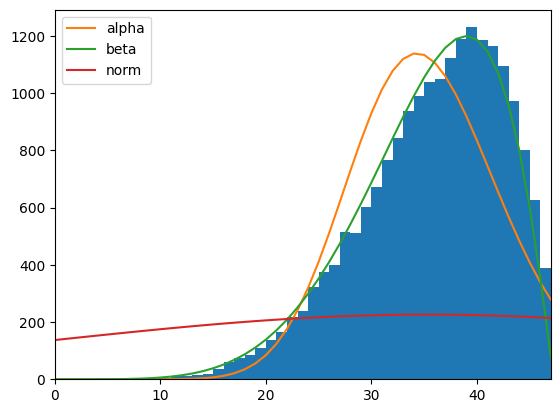

In [14]:
# EXAMPLE for distribution fitting

import scipy
import scipy.stats

size = 20000
x = np.arange(size)
# creating the dummy sample (using beta distribution)
y = np.round(scipy.stats.beta.rvs(6,2,size=size)*47)
# creating the histogram
h = plt.hist(y, bins=range(48))

# dist_names = ['alpha', 'beta', 'arcsine', 'norm', 'weibull_min', 'weibull_max', 'rayleigh']
dist_names = [ 'alpha', 'beta', 'norm' ]

for dist_name in dist_names:
    dist = getattr(scipy.stats, dist_name)
    params = dist.fit(y)
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]
    print(f"{dist_name}: {arg}, {loc}, {scale}")
    if arg:
        pdf_fitted = dist.pdf(x, *arg, loc=loc, scale=scale) * size
    else:
        pdf_fitted = dist.pdf(x, loc=loc, scale=loc) * size
    plt.plot(pdf_fitted, label=f"{dist_name}")
    plt.xlim(0,47)
plt.legend(loc='upper left')
plt.show()

data.shape=(4194304,)
norm: args=(), loc=1.339, scale=4.164
alpha: args=(3.73375136979385,), loc=-0.000, scale=0.000


C:\Users\ihals\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_continuous_distns.py:723: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))


beta: args=(0.5717306410743365, 269.4791908968493), loc=-0.000, scale=204.183
arcsine: args=(), loc=-0.000, scale=24.939
weibull_min: args=(0.20973512909079361,), loc=-0.000, scale=3.839
weibull_max: args=(0.30958824778023714,), loc=24.000, scale=1.649
rayleigh: args=(), loc=-3.887, scale=4.725


C:\Users\ihals\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_continuous_distns.py:8687: RuntimeWarning: overflow encountered in divide
  s3 = (1/xm).sum()


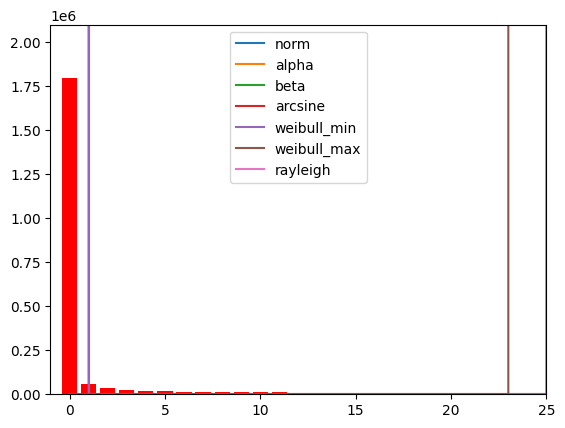

In [15]:
import scipy
import scipy.stats


file_path = r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\ISSI2-5\RT-60s-50dumps.txt-results\Votes-50.npy"
x = np.arange(NUM_WORDS)
data = np.load(file_path)
sample_size = NUM_WORDS // 10
sampled_data = np.random.choice(data, sample_size)
x_sampled = np.arange(sample_size)
size = 10

print(f"{data.shape=}")

num_bins = 50 + 1
hist, _ = np.histogram(data, num_bins)
plt.bar(range(num_bins), hist, color="red")
# plt.plot(range(num_bins), hist, color="red")

dist_names = [ 'norm', 'alpha', 'beta', 'arcsine', 'weibull_min', 'weibull_max', 'rayleigh', ]

for dist_name in dist_names:
    # print(f"{dist_name}...")

    dist = getattr(scipy.stats, dist_name)
    params = dist.fit(sampled_data[sampled_data < 25])
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    print(f"{dist_name}: args={arg}, loc={loc:.3f}, scale={scale:.3f}")

    if arg:
        pdf_fitted = dist.pdf(x_sampled, *arg, loc=loc, scale=scale) * size
    else:
        pdf_fitted = dist.pdf(x_sampled, loc=loc, scale=loc) * size

    plt.plot(pdf_fitted, label=f"{dist_name}")
    plt.xlim(-1, num_bins//2)
    plt.ylim(0, NUM_WORDS*8)

plt.legend(loc='upper center')
plt.show()

data.shape=(4194304,)


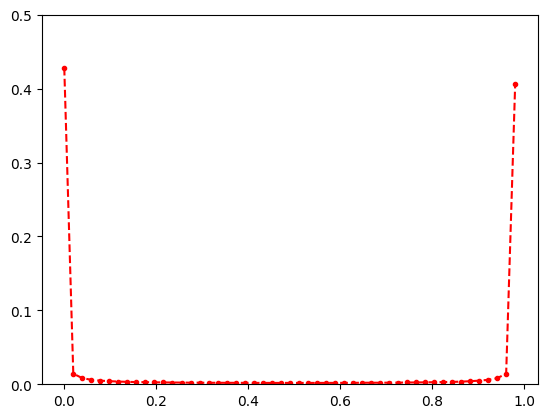

In [16]:
import scipy.stats

file_path = r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\ISSI2-5\RT-60s-50dumps.txt-results\Votes-50.npy"
x = np.arange(NUM_WORDS)
data = np.load(file_path)
sample_size = NUM_WORDS // 10
sampled_data = np.random.choice(data, sample_size)
x_sampled = np.arange(sample_size)
size = 10

print(f"{data.shape=}")

num_bins = 50 + 1
hist, _ = np.histogram(data, num_bins)

fig, ax = plt.subplots()
ax.plot(np.arange(num_bins)/num_bins, hist/NUM_BITS, '.--', color="red")
ax.set_ylim(0, 0.5)
plt.show()

Create distribution plots all side-by-side for the paper

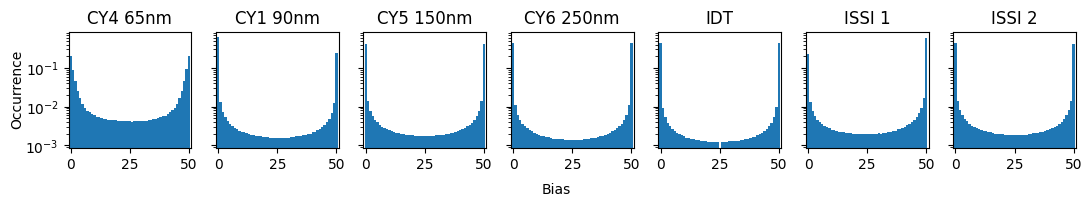

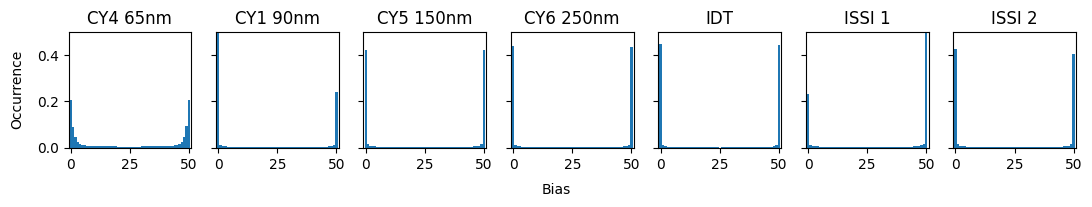

In [17]:
label_and_paths = [
    ("CY4 65nm", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY4-65nm-1\30C-30s-50dumps-2024.11.05.txt-results\Votes-50.npy"),
    ("CY1 90nm", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY1-90nm-2\RT-30s-50dumps.txt-results\Votes-50.npy"),
    ("CY5 150nm", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY5-150nm-2\50_captures_15_second_delay.txt-results\Votes-50.npy"),
    ("CY6 250nm", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY6-250nm-1\30C-60s-50dumps-2024.11.01.txt-results\Votes-50.npy"),
    ("IDT", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\IDT1-1\50_captures_15_second_delay.txt-results\Votes-49.npy"),
    ("ISSI 1", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\ISSI1-1\50_captures_15_second_delay.txt-results\Votes-50.npy"),
    ("ISSI 2", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\ISSI2-5\RT-60s-50dumps.txt-results\Votes-50.npy"),
]

for is_log in (True, False):
    fig, axs = plt.subplots(1, len(label_and_paths), sharex="row", sharey="row")
    fig.set_figwidth(6.5 *2)
    fig.set_figheight(0.75 *2)

    for i, label_and_path in enumerate(label_and_paths):
        label, path = label_and_path
        votes = np.load(path)
        hist, _ = np.histogram(votes, 51)
        axs[i].bar(range(51), hist / NUM_BITS, 1.0)
        axs[i].set_title(label)

    fig.gca().set_xlim(-1, 51)
    fig.gca().set_xticks([0, 25, 50])
    if not is_log:
        fig.gca().set_ylim(0, 0.5)
    else:
        fig.gca().set_yscale('log')
    # fig.set_xlabel("Bias")
    # fig.set_ylabel("Occurrence")
    fig.text(0.5, -0.2, 'Bias', ha='center')
    fig.text(0.08, 0.5, 'Occurrence', va='center', rotation='vertical')

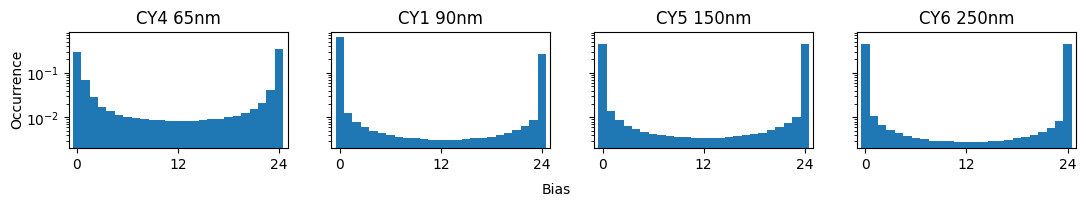

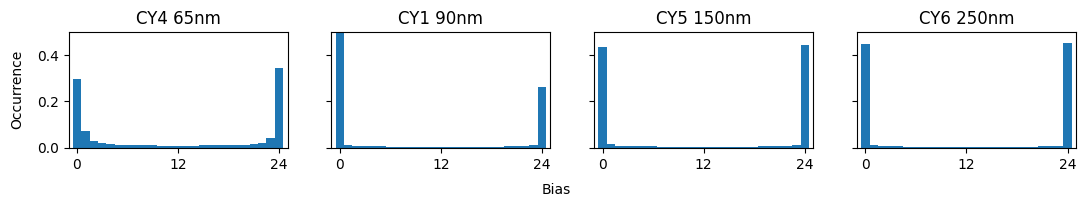

In [18]:
label_and_paths = [
    ("CY4 65nm", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY4-65nm-1\30C-30s-50dumps-2024.11.05.txt-results\Votes-50.npy"),
    ("CY1 90nm", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY1-90nm-2\RT-30s-50dumps.txt-results\Votes-50.npy"),
    ("CY5 150nm", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY5-150nm-2\50_captures_15_second_delay.txt-results\Votes-50.npy"),
    ("CY6 250nm", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY6-250nm-1\30C-60s-50dumps-2024.11.01.txt-results\Votes-50.npy"),
]

for is_log in (True, False):
    fig, axs = plt.subplots(1, len(label_and_paths), sharex="row", sharey="row")
    fig.set_figwidth(6.5 *2)
    fig.set_figheight(0.75 *2)

    for i, label_and_path in enumerate(label_and_paths):
        label, path = label_and_path
        votes = np.load(path)
        hist, _ = np.histogram(votes, 25)
        axs[i].bar(range(25), hist / NUM_BITS, 1.0)
        axs[i].set_title(label)

    fig.gca().set_xlim(-1, 25)
    fig.gca().set_xticks([0, 12, 24])
    if not is_log:
        fig.gca().set_ylim(0, 0.5)
    else:
        fig.gca().set_yscale('log')
    # fig.set_xlabel("Bias")
    # fig.set_ylabel("Occurrence")
    fig.text(0.5, -0.2, 'Bias', ha='center')
    fig.text(0.08, 0.5, 'Occurrence', va='center', rotation='vertical')
    plt.show()

Reusable function for creating more correlation plots

In [19]:
def correlation_matrix(file_list_rows: list[str], file_list_cols: list[str], correlation_function, load_function=np.load) -> np.ndarray:
    num_rows = len(file_list_rows)
    num_cols = len(file_list_cols)
    matrix = np.full((num_rows, num_cols), float("NaN"))
    for r in range(num_rows):
        data_a = load_function(file_list_rows[r])
        for c in range(num_cols):
            # Don't duplicate work because
            # It should be true that `correlation_function(a, b) == correlation_function(b, a)`
            if (c >= r):
                continue
            data_b = load_function(file_list_cols[c])
            matrix[r, c] = correlation_function(data_a, data_b)
    return matrix

Hamming distance baseline correlation plot

In [20]:
def hamming_distance(a: np.ndarray, b: np.ndarray) -> float:
    return np.sum(hw_vec_fn(np.bitwise_xor(a, b))) / NUM_BITS

In [21]:
def correlation_matrix_plot(labeled_paths: np.ndarray, correlation_function, load_function=np.load):
    not_found = []
    for fname in labeled_paths[:, 1]:
        if not os.path.isfile(fname):
            not_found.append(fname)
    if not_found:
        raise FileNotFoundError("These files: " + ("\n* ".join(not_found)))

    c_mat = correlation_matrix(labeled_paths[:,1], labeled_paths[:,1], correlation_function, load_function)
    axis_n = range(labeled_paths.shape[0] - 1)
    axes_img = plt.imshow(c_mat[1:,:-1])
    plt.gca().set_xticks(axis_n, labels=labeled_paths[:-1, 0])
    plt.gca().set_yticks(axis_n, labels=labeled_paths[1:, 0])
    colorbar = plt.colorbar()
    return axes_img, colorbar

Text(0.5, 1.0, 'Hamming distance')

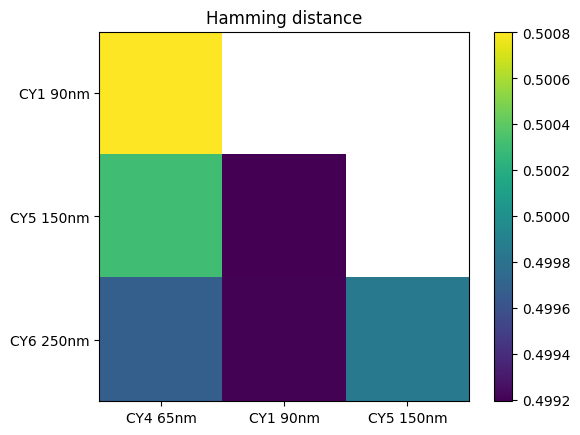

In [22]:
labeled_paths = np.array([
    ("CY4 65nm", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY4-65nm-1\30C-30s-50dumps-2024.11.05.txt-results\Captures-50.npy"),
    ("CY1 90nm", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY1-90nm-2\RT-30s-50dumps.txt-results\Captures-50.npy"),
    ("CY5 150nm", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY5-150nm-2\50_captures_15_second_delay.txt-results\Captures-50.npy"),
    ("CY6 250nm", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY6-250nm-1\30C-60s-50dumps-2024.11.01.txt-results\Captures-50.npy"),
])

correlation_matrix_plot(labeled_paths, hamming_distance, load_function=lambda f: np.load(f)[0])
plt.title("Hamming distance")

Recreate the bit stability distribution distance

In [23]:
import numpy as np

labeled_files_votes = np.array((
    ("CY 65", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY4-65nm-1\30C-30s-50dumps-2024.11.05.txt-results\Votes-50.npy"),
    ("CY 65", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY4-65nm-2\RT-30s-50dumps-2024.10.21.txt-results\Votes-50.npy"),
    ("CY 65", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY4-65nm-3\RT-30s-50dumps-2022.10.22.txt-results\Votes-50.npy"),
    ("CY 65", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY4-65nm-4\RT-30s-50dumps.txt-results\Votes-50.npy"),
    ("CY 65", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY4-65nm-5\RT-30s-50dumps.txt-results\Votes-50.npy"),
    ("CY 90", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY1-90nm-1\50_captures_15_second_delay.txt-results\Votes-50.npy"),
    ("CY 90", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY1-90nm-2\RT-30s-50dumps.txt-results\Votes-50.npy"),
    ("CY 90", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY1-90nm-3\50_captures_15_second_delay.txt-results\Votes-50.npy"),
    ("CY 90", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY1-90nm-4\50_captures_15_second_delay.txt-results\Votes-50.npy"),
    ("CY 90", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY1-90nm-5\50_captures_15_second_delay.txt-results\Votes-50.npy"),
    ("CY 150", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY5-150nm-2\50_captures_15_second_delay.txt-results\Votes-50.npy"),
    ("CY 150", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY5-150nm-3\50_captures_15_second_delay.txt-results\Votes-50.npy"),
    ("CY 150", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY5-150nm-4\50_captures_15_second_delay.txt-results\Votes-50.npy"),
    ("CY 150", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY5-150nm-5\RT-30s-50dumps.txt-results\Votes-20.npy"),
    ("CY 250", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY6-250nm-1\RT-30s-50dumps-2024.10.22.txt-results\Votes-50.npy"),
    ("CY 250", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY6-250nm-2\RT-30s-50dumps-2024.10.22.txt-results\Votes-50.npy"),
    ("CY 250", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY6-250nm-3\2024.10.22-normal-30s-50dumps.txt-results\Votes-50.npy"),
    ("CY 250", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY6-250nm-4\RT-60s-50dumps.txt-results\Votes-49.npy"),
    ("IDT", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\IDT1-1\50_captures_15_second_delay.txt-results\Votes-49.npy"),
    ("IDT", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\IDT1-3\RT-60s-50dumps.txt-results\Votes-50.npy"),
    ("IDT", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\IDT1-4\RT-60s-50dumps.txt-results\Votes-50.npy"),
    ("IDT", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\IDT1-5\RT-60s-50dumps.txt-results\Votes-50.npy"),
    ("ISSI 1", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\ISSI1-1\50_captures_15_second_delay.txt-results\Votes-50.npy"),
    ("ISSI 1", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\ISSI1-2\50_captures_15_second_delay.txt-results\Votes-50.npy"),
    ("ISSI 1", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\ISSI1-3\50_captures_30_second_delay.txt-results\Votes-50.npy"),
    ("ISSI 2", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\ISSI2-1\RT-60s-50dumps.txt-results\Votes-50.npy"),
    ("ISSI 2", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\ISSI2-2\RT-60s-50dumps.txt-results\Votes-50.npy"),
    ("ISSI 2", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\ISSI2-3\RT-60s-50dumps.txt-results\Votes-50.npy"),
    ("ISSI 2", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\ISSI2-4\RT-60s-50dumps.txt-results\Votes-50.npy"),
    ("ISSI 2", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\ISSI2-5\RT-60s-50dumps.txt-results\Votes-50.npy"),
))

labeled_files_captures = np.array((
    ("CY1 ", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY1-90nm-2\RT-30s-50dumps.txt-results\Captures-50.npy"),
    ("CY4 ", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY4-65nm-1\30C-30s-50dumps-2024.11.05.txt-results\Captures-50.npy"),
    ("CY4 ", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY4-65nm-2\RT-30s-50dumps-2024.10.21.txt-results\Captures-50.npy"),
    ("CY4 ", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY4-65nm-3\RT-30s-50dumps-2022.10.22.txt-results\Captures-50.npy"),
    # ("CY4 ", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY4-65nm-4\RT-30s-50dumps.txt-results\Captures-50.npy"),
    # ("CY4 ", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY4-65nm-5\RT-30s-50dumps.txt-results\Captures-50.npy"),
    ("CY5 ", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY5-150nm-2\50_captures_15_second_delay.txt-results\Captures-50.npy"),
    ("CY5 ", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY5-150nm-3\50_captures_15_second_delay.txt-results\Captures-50.npy"),
    ("CY5 ", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY5-150nm-4\50_captures_15_second_delay.txt-results\Captures-50.npy"),
    # ("CY5 ", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY5-150nm-5\RT-30s-50dumps.txt-results\Captures-50.npy"),
    ("CY6 ", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY6-250nm-1\RT-30s-50dumps-2024.10.22.txt-results\Captures-50.npy"),
    ("CY6 ", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY6-250nm-2\RT-30s-50dumps-2024.10.22.txt-results\Captures-50.npy"),
    ("CY6 ", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY6-250nm-3\2024.10.22-normal-30s-50dumps.txt-results\Captures-50.npy"),
    # ("CY6 ", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY6-250nm-4\RT-60s-50dumps.txt-results\Captures-50.npy"),
    # ("IDT 1", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\IDT1-1\50_captures_15_second_delay.txt-results\Captures-41.npy"),
    ("IDT 3", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\IDT1-3\RT-60s-50dumps.txt-results\Captures-41.npy"),
    ("IDT 4", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\IDT1-4\RT-60s-50dumps.txt-results\Captures-41.npy"),
    ("IDT 5 ", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\IDT1-5\RT-60s-50dumps.txt-results\Captures-41.npy"),
    ("ISSI1 1", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\ISSI1-1\50_captures_15_second_delay.txt-results\Captures-41.npy"),
    ("ISSI1 2", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\ISSI1-2\50_captures_15_second_delay.txt-results\Captures-41.npy"),
    ("ISSI1 3", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\ISSI1-3\50_captures_30_second_delay.txt-results\Captures-41.npy"),
    ("ISSI2 1", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\ISSI2-1\RT-60s-50dumps.txt-results\Captures-41.npy"),
    ("ISSI2 2 ", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\ISSI2-2\RT-60s-50dumps.txt-results\Captures-41.npy"),
    ("ISSI2 3 ", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\ISSI2-3\RT-60s-50dumps.txt-results\Captures-41.npy"),
    ("ISSI2 4 ", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\ISSI2-4\RT-60s-50dumps.txt-results\Captures-41.npy"),
    ("ISSI2 5 ", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\ISSI2-5\RT-60s-50dumps.txt-results\Captures-41.npy"),
))

for L in (labeled_files_votes, labeled_files_captures):
    for path in L[:,1]:
        if not os.path.isfile(path):
            raise FileNotFoundError(path)

Use the files to create a stability distance matrix

[Text(0, 0, 'CY 65'),
 Text(1, 0, 'CY 65'),
 Text(2, 0, 'CY 65'),
 Text(3, 0, 'CY 65'),
 Text(4, 0, 'CY 65'),
 Text(5, 0, 'CY 90'),
 Text(6, 0, 'CY 90'),
 Text(7, 0, 'CY 90'),
 Text(8, 0, 'CY 90'),
 Text(9, 0, 'CY 90'),
 Text(10, 0, 'CY 150'),
 Text(11, 0, 'CY 150'),
 Text(12, 0, 'CY 150'),
 Text(13, 0, 'CY 150'),
 Text(14, 0, 'CY 250'),
 Text(15, 0, 'CY 250'),
 Text(16, 0, 'CY 250'),
 Text(17, 0, 'CY 250'),
 Text(18, 0, 'IDT'),
 Text(19, 0, 'IDT'),
 Text(20, 0, 'IDT'),
 Text(21, 0, 'IDT'),
 Text(22, 0, 'ISSI 1'),
 Text(23, 0, 'ISSI 1'),
 Text(24, 0, 'ISSI 1'),
 Text(25, 0, 'ISSI 2'),
 Text(26, 0, 'ISSI 2'),
 Text(27, 0, 'ISSI 2'),
 Text(28, 0, 'ISSI 2')]

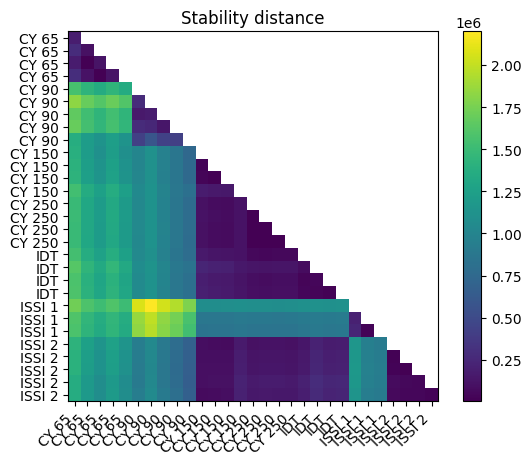

In [24]:
def stability_distance(votes_a: np.ndarray, votes_b: np.ndarray, num_bins=51) -> float:
    hist_a, _ = np.histogram(votes_a, num_bins)
    hist_b, _ = np.histogram(votes_b, num_bins)
    return float(np.linalg.norm(hist_a - hist_b))


correlation_matrix_plot(labeled_files_votes, stability_distance)
plt.title("Stability distance")
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

Do correlation between the arrays of the stability histogram

[Text(0, 0, 'CY 65'),
 Text(1, 0, 'CY 65'),
 Text(2, 0, 'CY 65'),
 Text(3, 0, 'CY 65'),
 Text(4, 0, 'CY 65'),
 Text(5, 0, 'CY 90'),
 Text(6, 0, 'CY 90'),
 Text(7, 0, 'CY 90'),
 Text(8, 0, 'CY 90'),
 Text(9, 0, 'CY 90'),
 Text(10, 0, 'CY 150'),
 Text(11, 0, 'CY 150'),
 Text(12, 0, 'CY 150'),
 Text(13, 0, 'CY 150'),
 Text(14, 0, 'CY 250'),
 Text(15, 0, 'CY 250'),
 Text(16, 0, 'CY 250'),
 Text(17, 0, 'CY 250'),
 Text(18, 0, 'IDT'),
 Text(19, 0, 'IDT'),
 Text(20, 0, 'IDT'),
 Text(21, 0, 'IDT'),
 Text(22, 0, 'ISSI 1'),
 Text(23, 0, 'ISSI 1'),
 Text(24, 0, 'ISSI 1'),
 Text(25, 0, 'ISSI 2'),
 Text(26, 0, 'ISSI 2'),
 Text(27, 0, 'ISSI 2'),
 Text(28, 0, 'ISSI 2')]

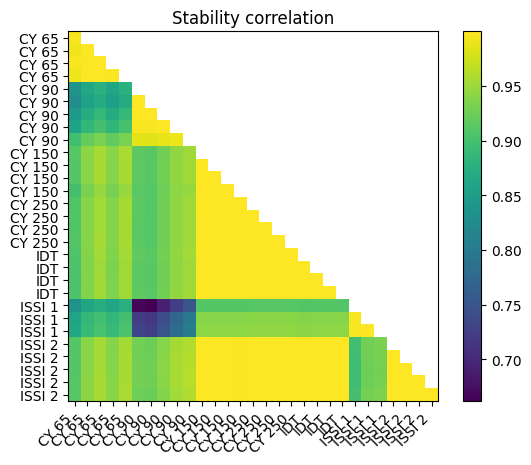

In [25]:
def stability_correlation(votes_a: np.ndarray, votes_b: np.ndarray, num_bins=51) -> float:
    hist_a, _ = np.histogram(votes_a, num_bins)
    hist_b, _ = np.histogram(votes_b, num_bins)
    return pearsonr(hist_a, hist_b).correlation


correlation_matrix_plot(labeled_files_votes, stability_correlation)
plt.title("Stability correlation")
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


How does the log of it look?

C:\Users\ihals\AppData\Local\Temp\ipykernel_3148\2656852557.py:4: RuntimeWarning: divide by zero encountered in log
  return float(np.linalg.norm(np.log(hist_a) - np.log(hist_b)))
C:\Users\ihals\AppData\Local\Temp\ipykernel_3148\2656852557.py:4: RuntimeWarning: invalid value encountered in subtract
  return float(np.linalg.norm(np.log(hist_a) - np.log(hist_b)))


[Text(0, 0, 'CY 65'),
 Text(1, 0, 'CY 65'),
 Text(2, 0, 'CY 65'),
 Text(3, 0, 'CY 65'),
 Text(4, 0, 'CY 65'),
 Text(5, 0, 'CY 90'),
 Text(6, 0, 'CY 90'),
 Text(7, 0, 'CY 90'),
 Text(8, 0, 'CY 90'),
 Text(9, 0, 'CY 90'),
 Text(10, 0, 'CY 150'),
 Text(11, 0, 'CY 150'),
 Text(12, 0, 'CY 150'),
 Text(13, 0, 'CY 150'),
 Text(14, 0, 'CY 250'),
 Text(15, 0, 'CY 250'),
 Text(16, 0, 'CY 250'),
 Text(17, 0, 'CY 250'),
 Text(18, 0, 'IDT'),
 Text(19, 0, 'IDT'),
 Text(20, 0, 'IDT'),
 Text(21, 0, 'IDT'),
 Text(22, 0, 'ISSI 1'),
 Text(23, 0, 'ISSI 1'),
 Text(24, 0, 'ISSI 1'),
 Text(25, 0, 'ISSI 2'),
 Text(26, 0, 'ISSI 2'),
 Text(27, 0, 'ISSI 2'),
 Text(28, 0, 'ISSI 2')]

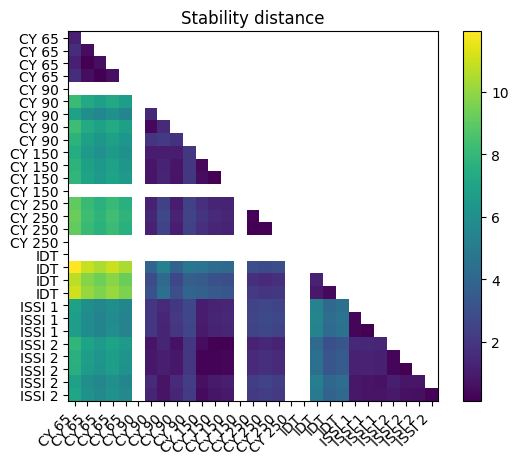

In [26]:
def stability_distance_log(votes_a: np.ndarray, votes_b: np.ndarray, num_bins=51) -> float:
    hist_a, _ = np.histogram(votes_a, num_bins)
    hist_b, _ = np.histogram(votes_b, num_bins)
    return float(np.linalg.norm(np.log(hist_a) - np.log(hist_b)))


correlation_matrix_plot(labeled_files_votes, stability_distance_log)
plt.title("Stability distance")
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

How does the sqrt look?

[Text(0, 0, 'CY 65'),
 Text(1, 0, 'CY 65'),
 Text(2, 0, 'CY 65'),
 Text(3, 0, 'CY 65'),
 Text(4, 0, 'CY 65'),
 Text(5, 0, 'CY 90'),
 Text(6, 0, 'CY 90'),
 Text(7, 0, 'CY 90'),
 Text(8, 0, 'CY 90'),
 Text(9, 0, 'CY 90'),
 Text(10, 0, 'CY 150'),
 Text(11, 0, 'CY 150'),
 Text(12, 0, 'CY 150'),
 Text(13, 0, 'CY 150'),
 Text(14, 0, 'CY 250'),
 Text(15, 0, 'CY 250'),
 Text(16, 0, 'CY 250'),
 Text(17, 0, 'CY 250'),
 Text(18, 0, 'IDT'),
 Text(19, 0, 'IDT'),
 Text(20, 0, 'IDT'),
 Text(21, 0, 'IDT'),
 Text(22, 0, 'ISSI 1'),
 Text(23, 0, 'ISSI 1'),
 Text(24, 0, 'ISSI 1'),
 Text(25, 0, 'ISSI 2'),
 Text(26, 0, 'ISSI 2'),
 Text(27, 0, 'ISSI 2'),
 Text(28, 0, 'ISSI 2')]

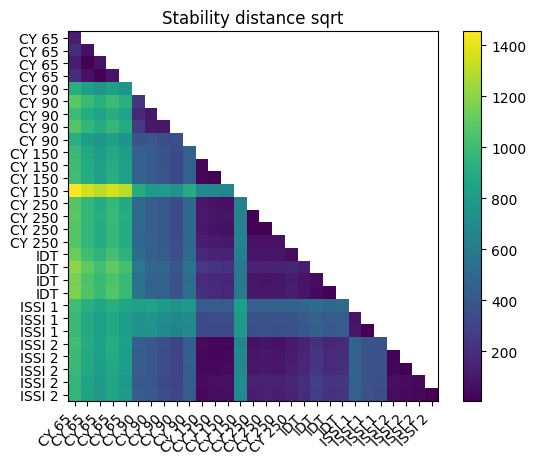

In [27]:
def stability_distance_sqrt(votes_a: np.ndarray, votes_b: np.ndarray, num_bins=51) -> float:
    hist_a, _ = np.histogram(votes_a, num_bins)
    hist_b, _ = np.histogram(votes_b, num_bins)
    return float(np.linalg.norm(np.sqrt(hist_a) - np.sqrt(hist_b)))


correlation_matrix_plot(labeled_files_votes, stability_distance_sqrt)
plt.title("Stability distance sqrt")
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

What if we only consider the stable or unstable bits?

In [28]:
def stability_distance_ends(votes_a: np.ndarray, votes_b: np.ndarray, num_bins=51) -> float:
    hist_a, _ = np.histogram(votes_a, num_bins)
    hist_b, _ = np.histogram(votes_b, num_bins)
    selected_a = np.array(( hist_a[0], hist_a[-1], ))
    selected_b = np.array(( hist_b[0], hist_b[-1], ))
    return float(np.linalg.norm(selected_a - selected_b))


def stability_distance_middle(votes_a: np.ndarray, votes_b: np.ndarray, num_bins=51) -> float:
    hist_a, _ = np.histogram(votes_a, num_bins)
    hist_b, _ = np.histogram(votes_b, num_bins)
    selected_a = hist_a[1:-1]
    selected_b = hist_b[1:-1]
    return float(np.linalg.norm(selected_a - selected_b))

In [29]:
correlation_matrix_plot(labeled_files_votes, stability_distance_middle)
plt.title("Stability distance, middle only")
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

KeyboardInterrupt: 

In [ ]:
correlation_matrix_plot(labeled_files_votes, stability_distance_ends)
plt.title("Stability distance, ends only")
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

In [ ]:
def stability_correlation_middle(votes_a: np.ndarray, votes_b: np.ndarray, num_bins=51) -> float:
    hist_a, _ = np.histogram(votes_a, num_bins)
    hist_b, _ = np.histogram(votes_b, num_bins)
    selected_a = hist_a[1:-1]
    selected_b = hist_b[1:-1]
    return pearsonr(selected_a, selected_b).correlation

NameError: name 'np' is not defined

In [ ]:
correlation_matrix_plot(labeled_files_votes, stability_correlation_middle)
plt.title("Stability correlation, middle only")
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

In [30]:
import math

def hamming_weight_difference(data_a: np.ndarray, data_b: np.ndarray) -> float:
    return math.fabs(np.sum(hw_vec_fn(data_a)) - np.sum(hw_vec_fn(data_b))) / NUM_BITS

In [ ]:
correlation_matrix_plot(labeled_files_captures, hamming_weight_difference, load_function=lambda p: np.load(p)[0])
plt.title("Hamming weight difference")
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

Create a high contrast heatmap visualization

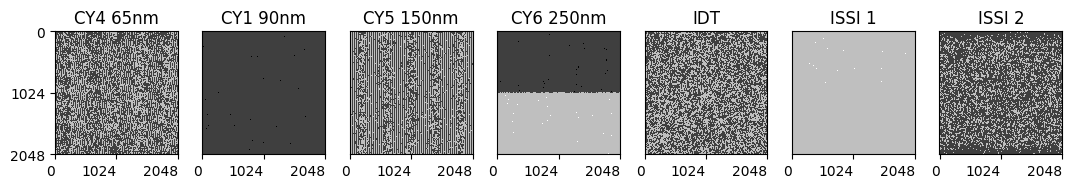

In [31]:
label_and_paths = [
    ("CY4 65nm", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY4-65nm-1\30C-30s-50dumps-2024.11.05.txt-results\Votes-50.npy"),
    ("CY1 90nm", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY1-90nm-2\RT-30s-50dumps.txt-results\Votes-50.npy"),
    ("CY5 150nm", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY5-150nm-2\50_captures_15_second_delay.txt-results\Votes-50.npy"),
    ("CY6 250nm", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY6-250nm-1\30C-60s-50dumps-2024.11.01.txt-results\Votes-50.npy"),
    ("IDT", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\IDT1-1\50_captures_15_second_delay.txt-results\Votes-49.npy"),
    ("ISSI 1", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\ISSI1-1\50_captures_15_second_delay.txt-results\Votes-50.npy"),
    ("ISSI 2", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\ISSI2-5\RT-60s-50dumps.txt-results\Votes-50.npy"),
]

color1 = np.array([0, 0, 0])
color2 = np.array([0.25, 0.25, 0.25])
color3 = np.array([0.75, 0.75, 0.75])
color4 = np.array([1, 1, 1])
colors_4_segments = np.ones((4, 3))
colors_4_segments[0] = color1
colors_4_segments[1] = color2
colors_4_segments[2] = color3
colors_4_segments[3] = color4
colormap_4 = ListedColormap(colors_4_segments)

fig = plt.figure()
fig.set_figwidth(6.5 *2)
fig.set_figheight(2 *2)
width = height = 2048 #1024
columns = len(label_and_paths)
rows = 1
ticks = [0, width/2, width]

for i, label_and_file_path in enumerate(label_and_paths):
    label, file_path = label_and_file_path
    bit_vote_counts = np.load(file_path)
    bit_count = width * height
    modified_arr = 2 * np.abs(bit_vote_counts - 0.5) # rescale bit vote 0/1 to stability
    a0 = 0
    img = np.reshape(modified_arr[a0 : a0 + bit_count], (width, height))
    big = width > 512 or height > 512
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(img, colormap_4, interpolation="bilinear")
    ax = plt.gca()
    ax.set_title(label)
    ax.set_xticks(ticks)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='right')
    if i == 0:
        ax.set_yticks(ticks)
    else:
        ax.set_yticks([])
# plt.colorbar(label='Bit stability (normalized)') 

Look at the blocks for bit interweaving in 150nm chip...

Do bit de-interleaving

In [ ]:
import numpy as np
import math

puf = np.load(r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY5-150nm-2\50_captures_15_second_delay.txt-results\Gold-PUF.npy")
block_img_size = int(math.sqrt(NUM_WORDS))
blocks = np.empty((BITS_PER_WORD, NUM_WORDS))

for i in range(NUM_WORDS):
    word = puf[i]
    for j in range(BITS_PER_WORD):
        b = 1 & (word >> j)
        assert(b == 0 or b == 1)
        blocks[j, i] = b

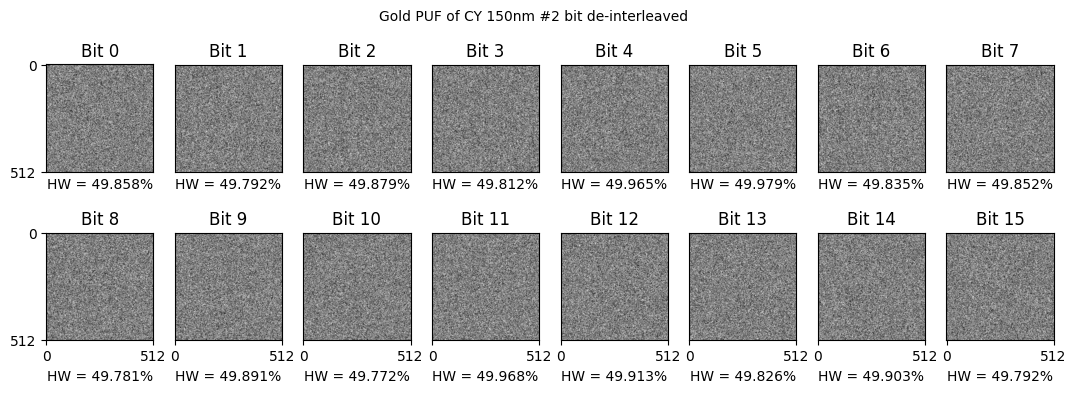

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_figwidth(6.5 *2)
fig.set_figheight(2 *2)

fig.text(0.5, 0.95, "Gold PUF of CY 150nm #2 bit de-interleaved", ha="center")

# slice = 128
slice = block_img_size
# slice = 64

for i in range(BITS_PER_WORD):
    block_img = blocks[i].reshape((block_img_size, block_img_size))[:slice,:slice]
    hamming_weight = 100 * np.sum(block_img) / (slice * slice)
    fig.add_subplot(2, 8, i + 1)
    plt.imshow(block_img, cmap="gray", interpolation="bilinear")
    ax = plt.gca()
    ax.set_xlabel(f"HW = {hamming_weight:0.3f}%")
    ax.set_title(f"Bit {i}")
    if i > 7:
        ax.set_xticks([0, slice])
    else:
        ax.set_xticks([])

    if i == 0 or i == 8:
        ax.set_yticks([0, slice])    
    else:
        ax.set_yticks([])

Plot blocks all together in a contiguous array image

Text(0.5, 1.0, 'Gold PUF of CY 150 De-interleaved at reshaped into contiguous array')

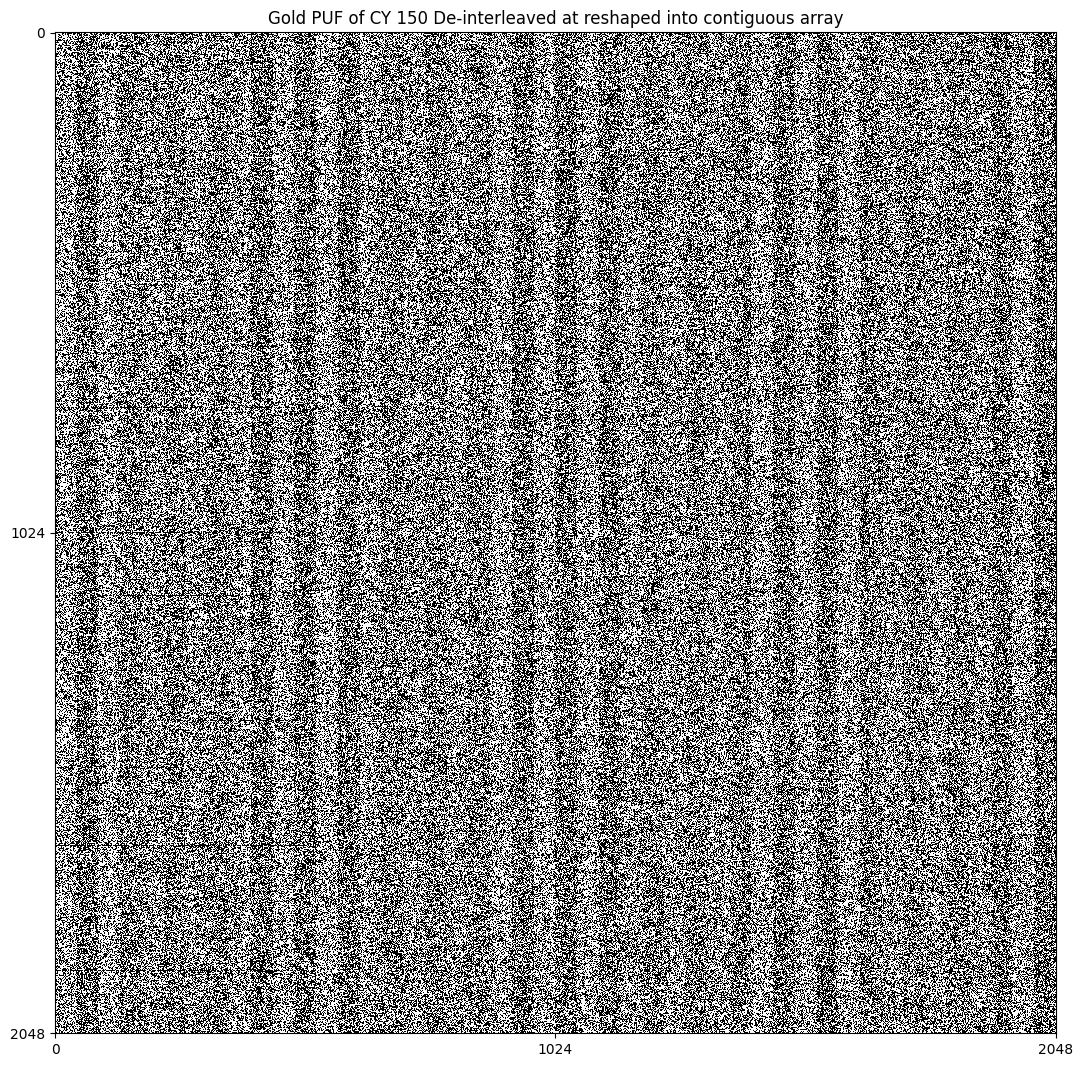

In [ ]:
fig = plt.figure()
fig.set_figwidth(6.5 *2)
fig.set_figheight(6.5 *2)
size = 2048
flat_blocks = blocks.reshape((2048, 2048))[:size,:size]
plt.imshow(flat_blocks, interpolation="none", cmap="gray")
ax = plt.gca()
ax.set_xticks([0, size//2, size])
ax.set_yticks([0, size//2, size])
ax.set_title("Gold PUF of CY 150 De-interleaved at reshaped into contiguous array")

Original CY 150nm image for comparison

In [ ]:
puf_bits = words_to_bits_np(puf)
fig = plt.figure()
fig.set_figwidth(6.5 *2)
fig.set_figheight(6.5 *2)
size = 2048
plt.imshow(puf_bits.reshape((size, size)), interpolation="bilinear", cmap="gray")
ax = plt.gca()
ax.set_xticks([0, size//2, size])
ax.set_yticks([0, size//2, size])
ax.set_title("Gold PUF of CY 150 Original")

NameError: name 'puf' is not defined

Plot bit bias histogram as a bar chart instead of a matrix

In [32]:
def correlation_matrix_create(labeled_paths: np.ndarray, correlation_function, load_function=np.load):
    not_found = []
    for fname in labeled_paths[:, 1]:
        if not os.path.isfile(fname):
            not_found.append(fname)
    if not_found:
        raise FileNotFoundError("These files:\n" + ("\n* ".join(not_found)))

    return correlation_matrix(labeled_paths[:,1], labeled_paths[:,1], correlation_function, load_function)

c_mat = correlation_matrix_create(labeled_files_votes, stability_correlation)

Fill in missing info of the half-matrix

In [ ]:
np.nan_to_num(c_mat, copy=False, nan=0)
for i in range(c_mat.shape[0]):
    c_mat[i,i] = 1.0
c_mat = c_mat + c_mat.T

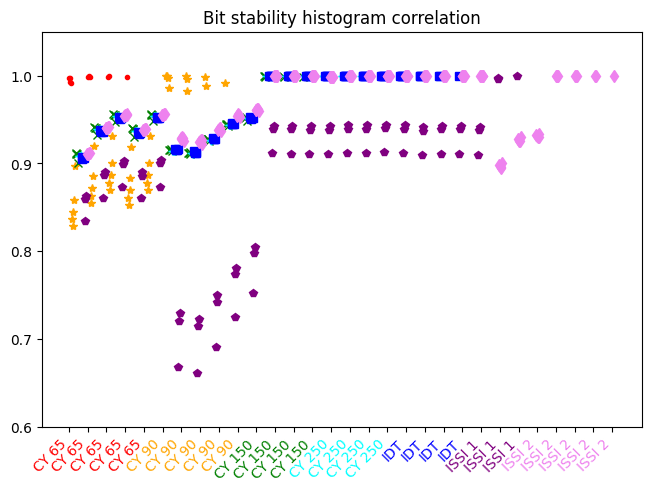

In [56]:
import numpy as np
import matplotlib.pyplot as plt

labels = list(labeled_files_votes[:, 0])
xs = np.arange(len(labels))
fig, ax = plt.subplots(layout='constrained')
width = 0.2

symbols = {
    "CY 65": ".",
    "CY 90": "*",
    "CY 150": "x",
    "CY 250": "+",
    "IDT": "s",
    "ISSI 1": "p",
    "ISSI 2": "d",
}

colors = {
    "CY 65": "red",
    "CY 90": "orange",
    "CY 150": "green",
    "CY 250": "cyan",
    "IDT": "blue",
    "ISSI 1": "purple",
    "ISSI 2": "violet",
}

for i, label in enumerate(labels):
    # ax.bar(xs*5 + width * i, c_mat[i], width=width, label=label)
    symbol = symbols[label]
    color = colors[label]
    ax.plot(xs*5 + width * i, c_mat[i], symbol, color=color, label=label)

ax.set_xticks(xs*5 + width, labels)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
# ax.legend(ncols=5)
ax.set_ylim(0.6, 1.05)
ax.set_title("Bit stability histogram correlation")

for i, label in enumerate(ax.xaxis.get_ticklabels()):
    label.set_color(colors[label.get_text()])

Text(0.5, 1.0, 'Stability correlation matrix visualized as bar')

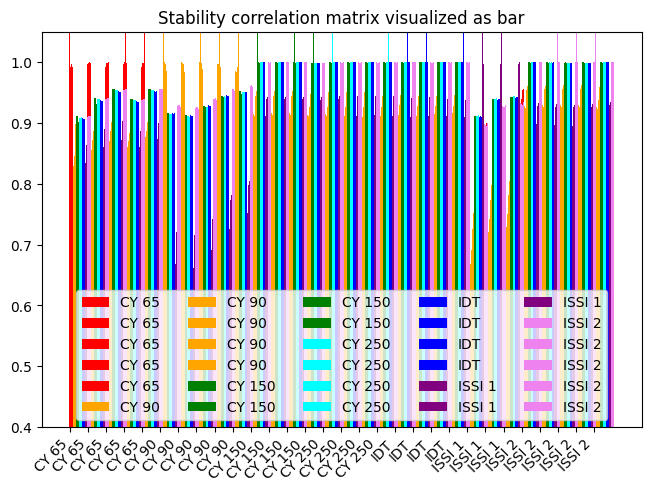

In [88]:
labels = list(labeled_files_votes[:, 0])
xs = np.arange(len(labels))
fig, ax = plt.subplots(layout='constrained')

width = 0.2

for i, label in enumerate(labels):
    ax.bar(xs*5 + width * i, c_mat[i], width=width, label=label, color=colors[label])

ax.set_xticks(xs*5 + width, labels)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.legend(loc="lower center", ncols=5)
ax.set_ylim(0.4, 1.05)
ax.set_title("Stability correlation matrix visualized as bar")

Visualizing more chips de-interleaved...

In [9]:
def de_interleave_bits_in_words(words: np.ndarray) -> np.ndarray:
    """Returns an array of bits"""
    blocks = np.empty((BITS_PER_WORD, NUM_WORDS))
    for i in range(NUM_WORDS):
        word = words[i]
        for j in range(BITS_PER_WORD):
            b = 1 & (word >> j)
            assert(b == 0 or b == 1)
            blocks[j, i] = b
    return blocks

(first load the data)

In [10]:
label_and_capture_paths = [
    ("CY4 65nm", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY4-65nm-1\30C-30s-50dumps-2024.11.05.txt-results\Gold-PUF.npy"),
    ("CY1 90nm", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY1-90nm-2\RT-30s-50dumps.txt-results\Gold-PUF.npy"),
    ("CY5 150nm", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY5-150nm-2\50_captures_15_second_delay.txt-results\Gold-PUF.npy"),
    ("CY6 250nm", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY6-250nm-1\30C-60s-50dumps-2024.11.01.txt-results\Gold-PUF.npy"),
    ("IDT", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\IDT1-1\50_captures_15_second_delay.txt-results\Gold-PUF.npy"),
    ("ISSI 1", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\ISSI1-1\50_captures_15_second_delay.txt-results\Gold-PUF.npy"),
    ("ISSI 2", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\ISSI2-5\RT-60s-50dumps.txt-results\Gold-PUF.npy"),
]

puf_list_orig = []
puf_list = []
for i, label_and_path in enumerate(label_and_capture_paths):
    label, path = label_and_path
    puf = np.load(path)
    puf_list.append(puf)
    puf_list.append(de_interleave_bits_in_words(puf))

now plot

ValueError: cannot reshape array of size 1 into shape (2048,2048)

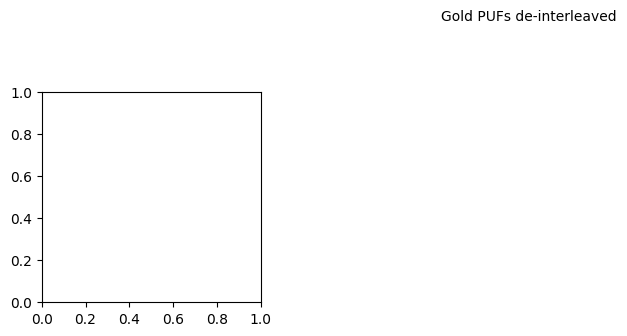

In [11]:
fig = plt.figure()
fig.text(0.5, 1, "Gold PUFs de-interleaved", ha="center")
fig.set_figwidth(6.5 *2)
fig.set_figheight(3 *2)
size = 2048
for i, label_and_path in enumerate(label_and_capture_paths):
    label, path = label_and_path
    fig.add_subplot(2, 4, i + 1)
    block_img = puf[i]
    plt.imshow(block_img.reshape(2048, 2048)[:size,:size], cmap="gray", interpolation="bilinear")
    ax = plt.gca()
    ax.set_title(label)
    if i > 2:
        ax.set_xticks([0, size//2, size])
    else:
        ax.set_xticks([])

    if i == 0 or i == 4:
        ax.set_yticks([0, size//2, size])
    else:
        ax.set_yticks([])

## Curve fitting the bit bias histograms

Looks like a quadratic in log plot,
so it can probably be fit by something of the form
log(y) = ax^2 + bx + c
or
y = e^(ax^2 + bx + c)

(14.662810846919957, 11.376418220315566, 10.788576533267019, 10.467834985704485, 10.242456669355928, 10.105039677606861, 9.964864832211031, 9.857181799659617, 9.784647708654596, 9.695171035465087, 9.659630959624376, 9.616005460087013, 9.581834960513193, 9.544237868224927, 9.502412792729256, 9.4776156346503, 9.467614782006539, 9.440975789048688, 9.436280010592395, 9.430278792341444, 9.431481920619719, 9.428511581663834, 9.416297071867572, 9.420114955551439, 9.425451751593128, 9.399968503952575, 9.42754633062364, 9.410911062438, 9.402942238177694, 9.392411897514927, 9.393827915410107, 9.375854810453756, 9.379323364330956, 9.394909401310617, 9.408617295560266, 9.398478314091577, 9.430278792341444, 9.437077458800523, 9.49356251370587, 9.502860721068213, 9.53755560876329, 9.590350910611878, 9.65598726971718, 9.72136597574484, 9.808792183696804, 9.92098360015288, 10.081298953852196, 10.259096928959389, 10.557504015893034, 11.09625784235407, 13.75002438794931)


Text(0.5, 1.0, 'Histogram curve fit')

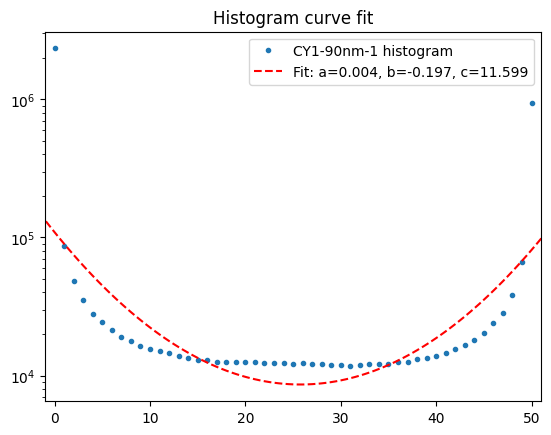

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import math

def func1(x, a, b, c):
    return a * x**2 + b * x + c

file_path = r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY1-90nm-1\50_captures_15_second_delay.txt-results\Votes-50.npy"
file_data = np.load(file_path)
votes_y, _ = np.histogram(file_data, bins=51)

# Fake data point to prevent an error coming from log(0) being called
votes_y[votes_y == 0] = math.exp(9.4)

votes_y_log = np.log(votes_y)
print(f"{tuple(votes_y_log)}")
xs = np.arange(votes_y.shape[0])

plt.plot(xs, votes_y, '.', label='CY1-90nm-1 histogram')

popt_1, pcov_1 = curve_fit(func1, xs, votes_y_log)
plot_fit_xs_1 = np.arange(-3, 53, 0.5)
a, b, c = popt_1
plt.plot(plot_fit_xs_1, np.exp(func1(plot_fit_xs_1, *popt_1)), 'r--', label=f'Fit: {a=:.3f}, {b=:.3f}, {c=:.3f}')

plt.gca().set_yscale('log')
plt.gca().set_xlim(-1, 51)
plt.legend()
plt.title("Histogram curve fit")


Lets compare for all chips...

(13.66060142391665, 12.849764315626924, 12.160593992251144, 11.575270958178935, 11.131650404163263, 10.823292103710079, 10.594682829370829, 10.411268546115894, 10.31463647711259, 10.22230485391862, 10.134043563565792, 10.059080049588058, 10.021048341275273, 9.961709289736252, 9.93226935396158, 9.91175329695316, 9.87996300748917, 9.8513517981156, 9.836759970485419, 9.824444345195674, 9.803501457660202, 9.79473239269909, 9.792667717430884, 9.765202019731785, 9.77286620732769, 9.764742592858719, 9.763305521936266, 9.76984186766621, 9.782336350971978, 9.793616881400416, 9.809726172721653, 9.810714152383774, 9.822385951099086, 9.865993348108548, 9.877297569445886, 9.888221618865694, 9.927204079153444, 9.971800192718215, 10.014671081496743, 10.072512770162733, 10.11795356265665, 10.198802917143304, 10.3082524155299, 10.431081793877356, 10.59403134722596, 10.827329700563117, 11.138173832018008, 11.57661362465296, 12.168500572622417, 12.861167430188374, 13.670081236290727)
(14.767757449361108,

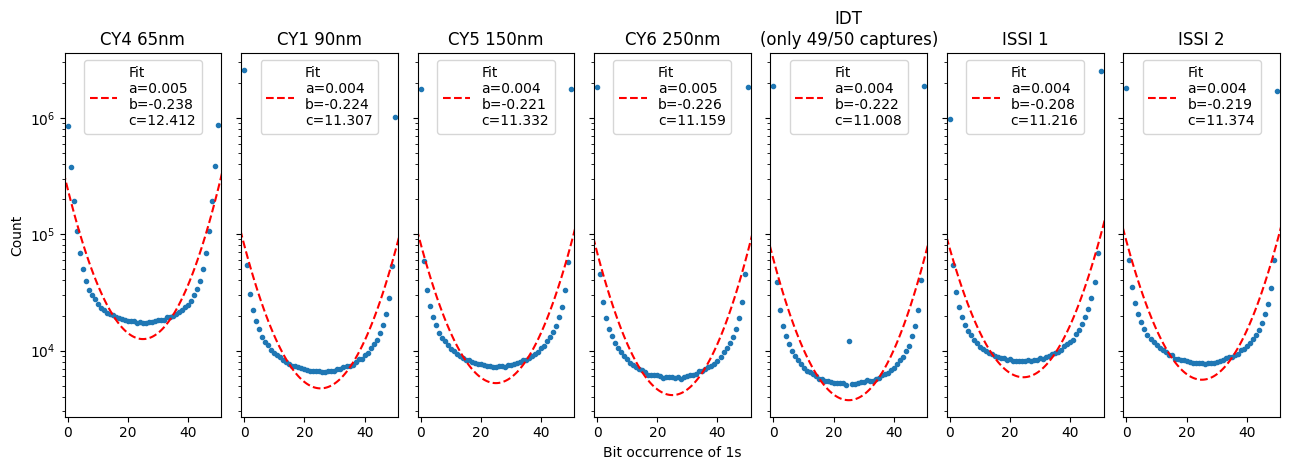

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import math

label_and_votes_paths = [
    ("CY4 65nm", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY4-65nm-1\30C-30s-50dumps-2024.11.05.txt-results\Votes-50.npy"),
    ("CY1 90nm", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY1-90nm-2\RT-30s-50dumps.txt-results\Votes-50.npy"),
    ("CY5 150nm", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY5-150nm-2\50_captures_15_second_delay.txt-results\Votes-50.npy"),
    ("CY6 250nm", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY6-250nm-1\30C-60s-50dumps-2024.11.01.txt-results\Votes-50.npy"),
    ("IDT\n(only 49/50 captures)", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\IDT1-1\50_captures_15_second_delay.txt-results\Votes-49.npy"),
    ("ISSI 1", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\ISSI1-1\50_captures_15_second_delay.txt-results\Votes-50.npy"),
    ("ISSI 2", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\ISSI2-5\RT-60s-50dumps.txt-results\Votes-50.npy"),
]

def func1(x, a, b, c):
    return a * x**2 + b * x + c

fig, axs = plt.subplots(ncols=len(label_and_votes_paths), sharey="row", layout="tight")
fig.set_figwidth(6.5 *2)

for i, label_and_file_path in enumerate(label_and_votes_paths):
    label, file_path = label_and_file_path

    file_data = np.load(file_path)
    votes_y, _ = np.histogram(file_data, bins=51)

    # Fake data point to prevent an error coming from log(0) being called
    votes_y[votes_y == 0] = math.exp(9.4)

    votes_y_log = np.log(votes_y)
    print(f"{tuple(votes_y_log)}")
    xs = np.arange(votes_y.shape[0])

    ax = axs[i]
    # ax.plot(xs, votes_y, '.', label='Vote histogram')
    ax.plot(xs, votes_y, '.')

    popt_1, pcov_1 = curve_fit(func1, xs, votes_y_log)
    plot_fit_xs_1 = np.arange(-3, 53, 0.5)
    a, b, c = popt_1
    ax.plot(plot_fit_xs_1, np.exp(func1(plot_fit_xs_1, *popt_1)), 'r--', label=f'Fit\n{a=:.3f}\n{b=:.3f}\n{c=:.3f}')

    if i == 3:
        ax.set_xlabel("Bit occurrence of 1s")
    if i == 0:
        ax.set_ylabel("Count")
    ax.set_yscale('log')
    ax.set_xlim(-1, 51)
    ax.legend(loc="upper center")
    ax.set_title(f"{label}")


Does it vary per bit location in the word? (per-block)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import math

label_and_votes_paths = [
    ("CY4 65nm", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY4-65nm-1\30C-30s-50dumps-2024.11.05.txt-results\Votes-50.npy"),
    ("CY1 90nm", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY1-90nm-2\RT-30s-50dumps.txt-results\Votes-50.npy"),
    ("CY5 150nm", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY5-150nm-2\50_captures_15_second_delay.txt-results\Votes-50.npy"),
    ("CY6 250nm", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY6-250nm-1\30C-60s-50dumps-2024.11.01.txt-results\Votes-50.npy"),
    ("IDT\n(only 49/50 captures)", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\IDT1-1\50_captures_15_second_delay.txt-results\Votes-49.npy"),
    ("ISSI 1", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\ISSI1-1\50_captures_15_second_delay.txt-results\Votes-50.npy"),
    ("ISSI 2", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\ISSI2-5\RT-60s-50dumps.txt-results\Votes-50.npy"),
]

def func1(x, a, b, c):
    return a * x**2 + b * x + c

fig, axs = plt.subplots(nrows=BITS_PER_WORD, ncols=len(label_and_votes_paths), sharey="row", layout="tight")
fig.set_figwidth(6.5 *2)
fig.set_figheight(6.5 *5)

for i, label_and_file_path in enumerate(label_and_votes_paths):
    label, file_path = label_and_file_path

    file_data = np.load(file_path)

    for j in range(BITS_PER_WORD):
        votes_y, _ = np.histogram(file_data[j::BITS_PER_WORD], bins=51)

        # Fake data point to prevent an error coming from log(0) being called
        votes_y[votes_y == 0] = math.exp(9.4)

        votes_y_log = np.log(votes_y)
        print(f"{tuple(votes_y_log)}")
        xs = np.arange(votes_y.shape[0])

        ax = axs[j, i]
        # ax.plot(xs, votes_y, '.', label='Vote histogram')
        ax.plot(xs, votes_y, '.')

        popt_1, pcov_1 = curve_fit(func1, xs, votes_y_log)
        plot_fit_xs_1 = np.arange(-3, 53, 0.5)
        a, b, c = popt_1
        ax.plot(plot_fit_xs_1, np.exp(func1(plot_fit_xs_1, *popt_1)), 'r--', label=f'Fit\n{a=:.3f}\n{b=:.3f}\n{c=:.3f}')

        # if i == 3:
        #     ax.set_xlabel("Bit occurrence of 1s")
        # if i == 0:
        #     ax.set_ylabel("Count")
        # ax.set_yscale('log')
        # ax.set_xlim(-1, 51)
        # ax.legend(loc="upper center")
        ax.set_xlabel(f"{a=:.3f}\n{b=:.3f}\n{c=:.3f}")
        if j == 0:
            ax.set_title(f"{label}, bit={j}")
        else:
            ax.set_title(f"bit={j}")

None

trying a better fitting

(13.66060142391665, 12.849764315626924, 12.160593992251144, 11.575270958178935, 11.131650404163263, 10.823292103710079, 10.594682829370829, 10.411268546115894, 10.31463647711259, 10.22230485391862, 10.134043563565792, 10.059080049588058, 10.021048341275273, 9.961709289736252, 9.93226935396158, 9.91175329695316, 9.87996300748917, 9.8513517981156, 9.836759970485419, 9.824444345195674, 9.803501457660202, 9.79473239269909, 9.792667717430884, 9.765202019731785, 9.77286620732769, 9.764742592858719, 9.763305521936266, 9.76984186766621, 9.782336350971978, 9.793616881400416, 9.809726172721653, 9.810714152383774, 9.822385951099086, 9.865993348108548, 9.877297569445886, 9.888221618865694, 9.927204079153444, 9.971800192718215, 10.014671081496743, 10.072512770162733, 10.11795356265665, 10.198802917143304, 10.3082524155299, 10.431081793877356, 10.59403134722596, 10.827329700563117, 11.138173832018008, 11.57661362465296, 12.168500572622417, 12.861167430188374, 13.670081236290727)
(14.767757449361108,

C:\Users\ihals\AppData\Local\Temp\ipykernel_6988\2217939466.py:28: RuntimeWarning: overflow encountered in exp
  return a*np.exp(-b*x) + c*np.exp(d*x) + e
C:\Users\ihals\AppData\Local\Temp\ipykernel_6988\2217939466.py:52: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(fitting_func, xs, votes_y)
C:\Users\ihals\AppData\Local\Temp\ipykernel_6988\2217939466.py:56: RuntimeWarning: overflow encountered in exp
  ax.plot(plot_fit_xs, np.exp(fitting_func(plot_fit_xs, *popt)), 'r--', label=long_label)


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1200.

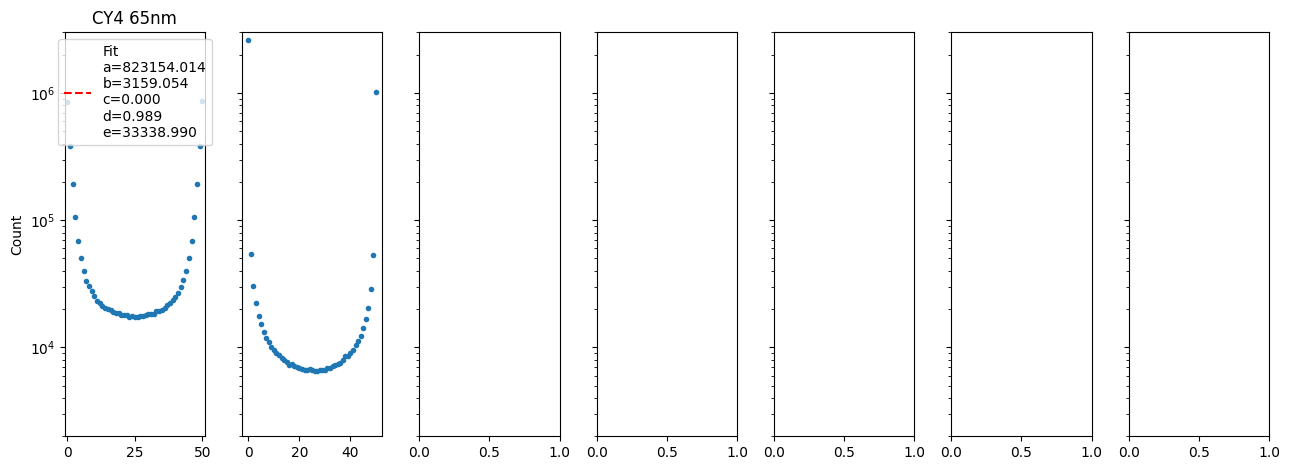

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

label_and_votes_paths = [
    ("CY4 65nm", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY4-65nm-1\30C-30s-50dumps-2024.11.05.txt-results\Votes-50.npy"),
    ("CY1 90nm", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY1-90nm-2\RT-30s-50dumps.txt-results\Votes-50.npy"),
    ("CY5 150nm", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY5-150nm-2\50_captures_15_second_delay.txt-results\Votes-50.npy"),
    ("CY6 250nm", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY6-250nm-1\30C-60s-50dumps-2024.11.01.txt-results\Votes-50.npy"),
    ("IDT\n(only 49/50 captures)", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\IDT1-1\50_captures_15_second_delay.txt-results\Votes-49.npy"),
    ("ISSI 1", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\ISSI1-1\50_captures_15_second_delay.txt-results\Votes-50.npy"),
    ("ISSI 2", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\ISSI2-5\RT-60s-50dumps.txt-results\Votes-50.npy"),
]

def func3(x, a, b, c):
    return a*x**2 + b*x + c

def func4(x, a, b, c, d):
    return a*x**3 + b*x**2 + c*x + d

def func5(x, a, b, c, d, e):
    return a*x**4 + b*x**3 + c*x**2 + d*x + e

def func7(x, a, b, c, d, e, f, g):
    return a*x**6 + b*x**5 + c*x**4 + d*x**3 + e*x**2 + f*x + g

def func_new(x, a, b, c, d, e):
    return a*np.exp(-b*x) + c*np.exp(d*x) + e

fitting_func = func_new

fig, axs = plt.subplots(ncols=len(label_and_votes_paths), sharey="row", layout="tight")
fig.set_figwidth(6.5 *2)

for i, label_and_file_path in enumerate(label_and_votes_paths):
    label, file_path = label_and_file_path

    file_data = np.load(file_path)
    votes_y, _ = np.histogram(file_data, bins=51)

    # Fake data point to prevent an error coming from log(0) being called
    votes_y[votes_y == 0] = votes_y[votes_y.shape[0]//2 - 1]

    votes_y_log = np.log(votes_y)
    print(f"{tuple(votes_y_log)}")
    xs = np.arange(votes_y.shape[0])

    ax = axs[i]
    # ax.plot(xs, votes_y, '.', label='Vote histogram')
    ax.plot(xs, votes_y, '.')

    popt_1, pcov_1 = curve_fit(fitting_func, xs, votes_y)
    plot_fit_xs_1 = np.arange(-3, 53, 0.5)
    alpha = "abcdefghijklmnop"
    long_label_1 = "Fit\n" + "\n".join([ f"{alpha[i]}={x:.3f}" for i, x in enumerate(popt_1) ])
    ax.plot(plot_fit_xs_1, np.exp(fitting_func(plot_fit_xs_1, *popt_1)), 'r--', label=long_label_1)

    if i == 3:
        # ax.set_xlabel("Bit occurrence of 1s")
        ax.set_xlabel("Log(y) = A*exp(-B*x) + C*exp(D*x) + E")
    if i == 0:
        ax.set_ylabel("Count")
    ax.set_yscale('log')
    ax.set_ylim(2e3, 3e6)
    ax.set_xlim(-1, 51)
    ax.set_xticks([0, 25, 50])
    ax.legend(loc="upper center")
    ax.set_title(f"{label}")


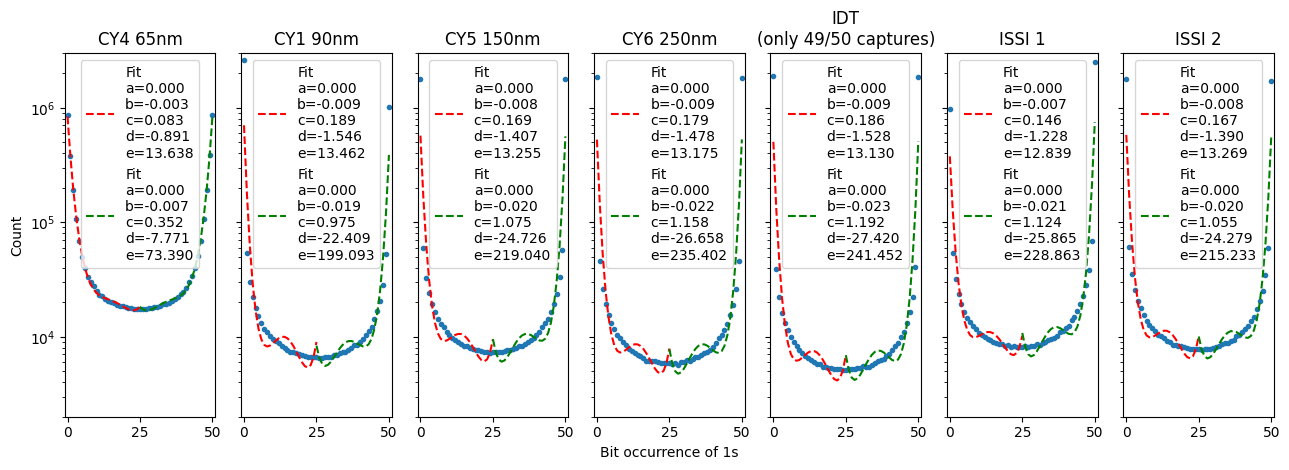

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

label_and_votes_paths = [
    ("CY4 65nm", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY4-65nm-1\30C-30s-50dumps-2024.11.05.txt-results\Votes-50.npy"),
    ("CY1 90nm", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY1-90nm-2\RT-30s-50dumps.txt-results\Votes-50.npy"),
    ("CY5 150nm", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY5-150nm-2\50_captures_15_second_delay.txt-results\Votes-50.npy"),
    ("CY6 250nm", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY6-250nm-1\30C-60s-50dumps-2024.11.01.txt-results\Votes-50.npy"),
    ("IDT\n(only 49/50 captures)", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\IDT1-1\50_captures_15_second_delay.txt-results\Votes-49.npy"),
    ("ISSI 1", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\ISSI1-1\50_captures_15_second_delay.txt-results\Votes-50.npy"),
    ("ISSI 2", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\ISSI2-5\RT-60s-50dumps.txt-results\Votes-50.npy"),
]

def func2(x, a, b):
    return a*x + b

def func3(x, a, b, c):
    return a*x**2 + b*x + c

def func4(x, a, b, c, d):
    return a*x**3 + b*x**2 + c*x + d

def func5(x, a, b, c, d, e):
    return a*x**4 + b*x**3 + c*x**2 + d*x + e

fitting_func = func5

fig, axs = plt.subplots(ncols=len(label_and_votes_paths), sharey="row", layout="tight")
fig.set_figwidth(6.5 *2)

for i, label_and_file_path in enumerate(label_and_votes_paths):
    label, file_path = label_and_file_path

    file_data = np.load(file_path)
    votes_y, _ = np.histogram(file_data, bins=51)

    # Fake data point to prevent an error coming from log(0) being called
    votes_y[votes_y == 0] = votes_y[votes_y.shape[0]//2 - 1]

    votes_y_log = np.log(votes_y)

    xs_1 = np.arange(votes_y.shape[0]//2 + 1)
    votes_y_1 = votes_y_log[:votes_y.shape[0]//2 + 1]
    xs_2 = np.arange(votes_y.shape[0]//2, votes_y.shape[0])
    votes_y_2 = votes_y_log[votes_y.shape[0]//2:]

    ax = axs[i]
    # ax.plot(xs, votes_y, '.', label='Vote histogram')
    ax.plot(xs, votes_y, '.')

    popt_1, pcov_1 = curve_fit(fitting_func, xs_1, votes_y_1, maxfev=2000)
    popt_2, pcov_2 = curve_fit(fitting_func, xs_2, votes_y_2, maxfev=2000)
    plot_fit_xs_1 = np.arange(-3, 25, 0.5)
    plot_fit_xs_2 = np.arange(25, 52, 0.5)
    alpha = "abcdefghijklmnop"
    long_label_1 = "Fit\n" + "\n".join([ f"{alpha[i]}={x:.3f}" for i, x in enumerate(popt_1) ])
    ax.plot(xs_1, np.exp(fitting_func(xs_1, *popt_1)), 'r--', label=long_label_1)
    long_label_2 = "Fit\n" + "\n".join([ f"{alpha[i]}={x:.3f}" for i, x in enumerate(popt_2) ])
    ax.plot(xs_2, np.exp(fitting_func(xs_2, *popt_2)), 'g--', label=long_label_2)

    if i == 3:
        ax.set_xlabel("Bit occurrence of 1s")
    if i == 0:
        ax.set_ylabel("Count")
    ax.set_yscale('log')
    ax.set_ylim(2e3, 3e6)
    ax.set_xlim(-1, 51)
    ax.set_xticks([0, 25, 50])
    ax.legend(loc="upper center")
    ax.set_title(f"{label}")


## Calculating error function

Find the error between many intra-family chips, and compare just a few representative inter-family chips.

Try error with histogram as absolute, and also as a percentage for each column.

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import os

first, here's the matrix function

In [50]:
def correlation_matrix(file_list_rows: list[str], file_list_cols: list[str], correlation_function, load_function=np.load) -> np.ndarray:
    num_rows = len(file_list_rows)
    num_cols = len(file_list_cols)
    matrix = np.full((num_rows, num_cols), float("NaN"))
    for r in range(num_rows):
        data_a = load_function(file_list_rows[r])
        for c in range(num_cols):
            # Don't duplicate work because
            # It should be true that `correlation_function(a, b) == correlation_function(b, a)`
            if (c >= r):
                continue
            data_b = load_function(file_list_cols[c])
            matrix[r, c] = correlation_function(data_a, data_b)
    return matrix


def correlation_matrix_create(labeled_paths: np.ndarray, correlation_function, load_function=np.load) -> np.ndarray:
    not_found = []
    for fname in labeled_paths[:, 1]:
        if not os.path.isfile(fname):
            not_found.append(fname)
    if not_found:
        raise FileNotFoundError("These files:\n" + ("\n* ".join(not_found)))

    return correlation_matrix(labeled_paths[:,1], labeled_paths[:,1], correlation_function, load_function)

here's the inter-family chips files to test

In [146]:
label_and_votes_paths = [
    ("CY4 65nm", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY4-65nm-1\30C-30s-50dumps-2024.11.05.txt-results\Votes-50.npy"),
    ("CY1 90nm", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY1-90nm-2\RT-30s-50dumps.txt-results\Votes-50.npy"),
    ("CY5 150nm", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY5-150nm-2\50_captures_15_second_delay.txt-results\Votes-50.npy"),
    ("CY6 250nm", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY6-250nm-1\30C-60s-50dumps-2024.11.01.txt-results\Votes-50.npy"),
    # ("IDT\n(only 49/50)", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\IDT1-1\50_captures_15_second_delay.txt-results\Votes-49.npy"),
    ("ISSI 1", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\ISSI1-1\50_captures_15_second_delay.txt-results\Votes-50.npy"),
    ("ISSI 2", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\ISSI2-5\RT-60s-50dumps.txt-results\Votes-50.npy"),
]

intra_65_label_and_votes_paths = [
    ("CY4 65nm 1", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY4-65nm-1\30C-30s-50dumps-2024.11.05.txt-results\Votes-50.npy"),
    ("CY4 65nm 2", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY4-65nm-2\30C-30s-50dumps-2024.11.05.txt-results\Votes-50.npy"),
    ("CY4 65nm 3", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY4-65nm-3\30C-60s-50dumps-2024.11.05.txt-results\Votes-50.npy"),
    ("CY4 65nm 4", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY4-65nm-4\RT-30s-50dumps.txt-results\Votes-50.npy"),
    ("CY4 65nm 5", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY4-65nm-5\RT-30s-50dumps.txt-results\Votes-50.npy"),
]

intra_90_label_and_votes_paths = [
    ("CY1 90nm 1", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY1-90nm-1\50_captures_15_second_delay.txt-results\Votes-50.npy"),
    ("CY1 90nm 2", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY1-90nm-2\RT-30s-50dumps.txt-results\Votes-50.npy"),
    ("CY1 90nm 3", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY1-90nm-3\50_captures_15_second_delay.txt-results\Votes-50.npy"),
    ("CY1 90nm 4", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY1-90nm-4\50_captures_15_second_delay.txt-results\Votes-50.npy"),
    ("CY1 90nm 5", r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY1-90nm-5\50_captures_15_second_delay.txt-results\Votes-50.npy"),
]

def votes_loader(fname: str, bins=51) -> np.ndarray:
    hist, _ = np.histogram(np.load(fname), bins=bins)
    return hist

chip_test_groups = [
    label_and_votes_paths,
    intra_65_label_and_votes_paths,
    intra_90_label_and_votes_paths
]

error functions to test

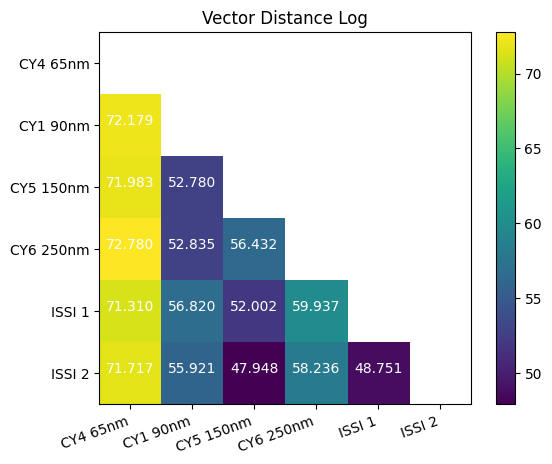

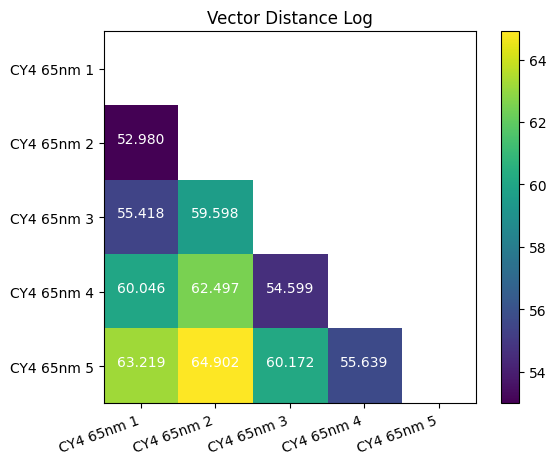

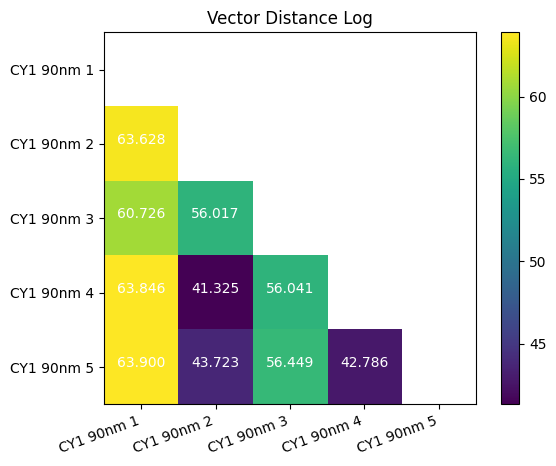

In [181]:
def absolute_vote_error(a: np.ndarray, b: np.ndarray) -> float:
    return np.sum(np.abs(a - b))

def absolute_log_error(a: np.ndarray, b: np.ndarray) -> float:
    ln_diff = np.log(np.abs(a - b))
    np.nan_to_num(ln_diff, nan=0, posinf=0, neginf=0, copy=False)
    return np.sum(ln_diff)

def l2_error(a: np.ndarray, b: np.ndarray) -> float:
    return np.linalg.norm(a - b)

def log_l2_error(a: np.ndarray, b: np.ndarray) -> float:
    ln_diff = np.log(np.abs(a - b))
    np.nan_to_num(ln_diff, nan=0, posinf=0, neginf=0, copy=False)
    return np.linalg.norm(ln_diff)

def div_log_error(a: np.ndarray, b: np.ndarray) -> float:
    ln_a = np.log(a)
    np.nan_to_num(ln_a, nan=0, neginf=0, posinf=0, copy=False)
    ln_b = np.log(b)
    np.nan_to_num(ln_b, nan=0, neginf=0, posinf=0, copy=False)
    return np.sum(np.abs(ln_a - ln_b))

def percent_vote_error(a: np.ndarray, b: np.ndarray) -> float:
    return np.mean(np.abs((a - b) / (a + 1)))

error_functions = {
    # "Absolute Error x10^6": absolute_vote_error,
    # "Percentage Error": percent_vote_error,
    # "Absolute Ln Error": absolute_log_error,
    # "Weird Ln Error": div_log_error,
    # "Vector Distance x10^6": l2_error,
    "Vector Distance Log": log_l2_error,
}

for i, pair in enumerate(error_functions.items()):
    title, func = pair
    for j, labels_and_paths in enumerate(chip_test_groups):
        labels_and_paths_np = np.array(labels_and_paths)
        err = correlation_matrix_create(labels_and_paths_np, func, votes_loader)
        plot_correlation_matrix_2(err,
                                  labels_and_paths_np[:,0],
                                  labels_and_paths_np[:,0],
                                  title=title,
                                  numbers="{x:.3f}")

direct template percentage mean square error

In [88]:

test_file_names = [
    r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY4-65nm-1\30C-30s-50dumps-2024.11.05.txt-results\Votes-50.npy",
    r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY1-90nm-1\50_captures_15_second_delay.txt-results\Votes-50.npy",
    # r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY1-90nm-2\RT-30s-50dumps.txt-results\Votes-50.npy",
    r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY5-150nm-2\50_captures_15_second_delay.txt-results\Votes-50.npy",
    r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY6-250nm-1\30C-60s-50dumps-2024.11.01.txt-results\Votes-50.npy",
    r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\IDT1-1\50_captures_15_second_delay.txt-results\Votes-49.npy",
    r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\ISSI1-1\50_captures_15_second_delay.txt-results\Votes-50.npy",
    r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\ISSI2-5\RT-60s-50dumps.txt-results\Votes-50.npy",
]

template_file_names_90 = [
    r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY1-90nm-1\50_captures_15_second_delay.txt-results\Votes-50.npy",
    # r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY1-90nm-2\RT-30s-50dumps.txt-results\Votes-50.npy",
    r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY1-90nm-3\50_captures_15_second_delay.txt-results\Votes-50.npy",
    r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY1-90nm-4\50_captures_15_second_delay.txt-results\Votes-50.npy",
    r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY1-90nm-5\50_captures_15_second_delay.txt-results\Votes-50.npy",
]

template_file_names_65 = [
    # r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY4-65nm-1\30C-30s-50dumps-2024.11.05.txt-results\Votes-50.npy",
    r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY4-65nm-2\30C-30s-50dumps-2024.11.05.txt-results\Votes-50.npy",
    r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY4-65nm-3\30C-60s-50dumps-2024.11.05.txt-results\Votes-50.npy",
    r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY4-65nm-4\RT-30s-50dumps.txt-results\Votes-50.npy",
    r"C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY4-65nm-5\RT-30s-50dumps.txt-results\Votes-50.npy",
]

template_file_names = template_file_names_65
votes_template: np.ndarray = np.zeros(NUM_BITS)
for template_file_name in template_file_names:
    votes = np.load(template_file_name)
    votes_template += votes
votes_template /= len(template_file_names)
# votes_template[2 < votes_template.any() < 47] = 25
# print(votes_template[120:140])

for test_file_name in test_file_names:
    print(test_file_name)
    votes_test = np.load(test_file_name)
    diffs = (votes_template - votes_test) ** 2
    diffs[np.where(np.logical_and(votes_template >= 4, votes_template <= 48))] = 0
    lse = np.sum(diffs)
    print(lse/(50))

C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY4-65nm-1\30C-30s-50dumps-2024.11.05.txt-results\Votes-50.npy
5776710.99125
C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY1-90nm-1\50_captures_15_second_delay.txt-results\Votes-50.npy
5705911.02125
C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY5-150nm-2\50_captures_15_second_delay.txt-results\Votes-50.npy
6311353.43125
C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\CY6-250nm-1\30C-60s-50dumps-2024.11.01.txt-results\Votes-50.npy
6357856.18125
C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\IDT1-1\50_captures_15_second_delay.txt-results\Votes-49.npy
6251057.07125
C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\ISSI1-1\50_captures_15_second_delay.txt-results\Votes-50.npy
6727489.68125
C:\Users\ihals\OneDrive - Colostate\RAM_Lab\Senior_Design\Data\ISSI2-5\RT-60s-50dumps.txt-results\Votes-50.npy
6268904.45125
